# Caso-taller:  Segmentación de Clientes con Clustering Jerárquico y DBSCAN

El objetivo de este caso-taller es analizar una base de datos ficticia sobre clientes de una tienda y buscar encontrar grupos de clientes que permitan generar estrategias de marketing focalizadas. La base se encuentra en los `Archivos de Laboratorio` en la carpeta `data` y cuenta con 200 observaciones y 5 variables:

- `Id_Cliente`: identificador de cliente.
- `Genero`: género del cliente: Mujer, Hombre
- `Edad`: edad en años
- `Ingreso`: ingresos anuales
- `Puntaje_Gasto`: es una variable que mide cuán a menudo un cliente compra en la tienda, siendo 100 el puntaje más alto.


## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo


In [1]:
!pip install kneed
!pip install gower
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gower
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import silhouette_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1.Carga de datos

En la carpeta `data` se encuentra el archivo `datos_clientes.csv` cargue estos datos en su *cuaderno*.

In [2]:
# Cargue de datos
df = pd.read_csv("https://raw.githubusercontent.com/ikteran/Segmentacion_Clientes_ANS/main/datos_clientes.csv")
df.head()

,Id_Cliente,Genero,Edad,Ingreso,Puntaje_Gasto
0,1,Mujer,41,98115.05,39
1,2,Mujer,20,35458.14,75
2,3,Mujer,68,59872.08,55
3,4,Hombre,63,48508.93,51
4,5,Mujer,31,44431.11,54


#### Procedimiento

**Procedimiento**
Se cargaron los datos a partir del repositorio en GitHub utilizando la libreria pandas. Adicionalmente, se muestra las primeras filas del dataframe.

### 2.Análisis preliminar.

Antes de comenzar el análisis de segmentación utilice estadísticas descriptivas para explorar la variables que se encuentran en los datos. En su análisis mencione si hay patrones que surgen del examen descriptivo de los datos; entre ellos si hay diferencias en los ingresos y los puntajes de gastos para mujeres y hombres, por grupos etarios (18-24, 25-34, 35-44, 45-54, 55-64, y 65+), y por grupos etarios y género. Discuta además si estas diferencias son estadísticamente significativas.

In [3]:
# Obtención de estadísticas descriptivas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id_Cliente,200.0,100.5000,57.879185,1.00,50.7500,100.50,150.250,200.00
Edad,200.0,38.8500,13.969007,18.00,28.7500,36.00,49.000,70.00
Ingreso,200.0,60624.4466,26262.903416,13458.02,41512.7875,60777.96,77143.865,138584.52
Puntaje_Gasto,200.0,50.2000,25.823522,1.00,34.7500,50.00,73.000,99.00


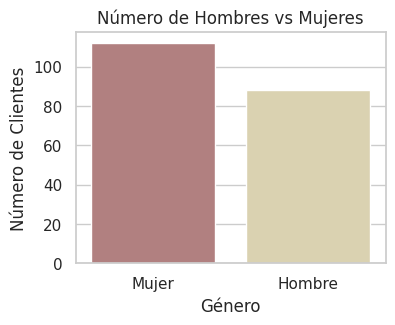

In [4]:
# Contar el número de hombres y mujeres
gender_counts = df['Genero'].value_counts()

# Configuración de estilo para las gráficas
sns.set(style="whitegrid")

# Crear la gráfica
plt.figure(figsize=(4, 3))
sns.barplot(x=gender_counts.index, y=gender_counts.values, hue=gender_counts.index, palette="pink", legend=False)
plt.title('Número de Hombres vs Mujeres')
plt.xlabel('Género')
plt.ylabel('Número de Clientes')
plt.show()

**Procedimiento**

Se obtienen las estadísticas descriptivas de cada variable como media, desviación estándar, minimo, máximo y los respectivos cuartiles con el propósito de analizar la base de datos. Adicionalmente, se obtiene y grafican el número de hombres y mujeres.

**Análisis**
- Los clientes tienen edades entre 18 y 70 años, sin embargo la mayoria tiene alrededor de 39 años. El 75% de los clientes tienen edades iguales o menores a 49 años.
- Los ingresos anuales varian entre 13.458 y 138.584 dolares, es decir que hay personas que pueden estar ganando 10 veces más que otras. La desviación estándar es bastante alta, lo que sugiere una gran dispersión en los ingresos. Sin embargo, el ingreso promedio está alrededor de 60.624 dolares.
- Respecto al cuan a menudo el cliente compra (Puntaje_Gasto) se puede observar que en la base de datos se encuentran clientes con baja y alta frecuencia ya que el rango está entre 1 y 99. El 75% de los clientes tiene un puntaje de alta recurrencia con valores iguales o menores a 73 puntos. En promedio los clientes tienen un puntaje de 50 puntos.
- La base de datos está conformada en su mayoria por mujeres

**Conclusiones**

Se tiene una amplia variedad de clientes en cuanto a sus ingresos y la mayoria son mujeres. Adiciionalmente, gran parte de los clientes tienen edades entre 29 y 49 años, lo que podria ser importante para analizar el poder adquisitivo.Finalmente, el 75% de los clientes tienen una alta frecuencia de compra con valores iguales o menores a 73 puntos.

#### Segmentación por género

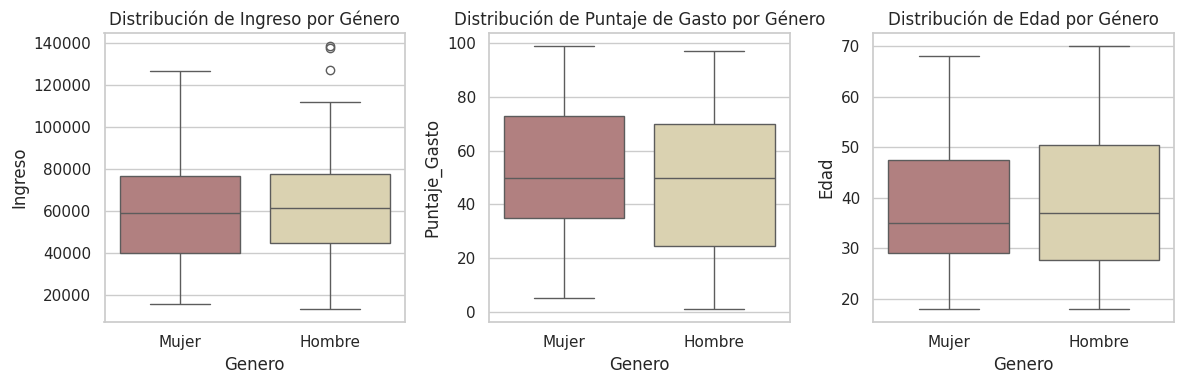

In [5]:
# Configuración de estilo para las gráficas
sns.set(style="whitegrid")

# Gráficas de estadísticas descriptivas por género
plt.figure(figsize=(12, 4))

# Ingreso por Género
plt.subplot(1, 3, 1)
sns.boxplot(x='Genero', y='Ingreso', data=df, hue='Genero', palette="pink", legend=False)
plt.title('Distribución de Ingreso por Género')

# Puntaje de Gasto por Género
plt.subplot(1, 3, 2)
sns.boxplot(x='Genero', y='Puntaje_Gasto', data=df, hue='Genero', palette="pink", legend=False)
plt.title('Distribución de Puntaje de Gasto por Género')

# Edad por Género
plt.subplot(1, 3, 3)
sns.boxplot(x='Genero', y='Edad', data=df, hue='Genero', palette="pink", legend=False)
plt.title('Distribución de Edad por Género')

plt.tight_layout()
plt.show()

In [6]:
# Agrupar por género y calcular estadísticas descriptivas
df_filtered = df.drop(columns=['Id_Cliente'])
desc_stats_genero = df_filtered.groupby('Genero').describe()
desc_stats_genero.T

Genero                      Hombre          Mujer
Edad          count      88.000000     112.000000
              mean       39.806818      38.098214
              std        15.514812      12.644095
              min        18.000000      18.000000
              25%        27.750000      29.000000
              50%        37.000000      35.000000
              75%        50.500000      47.500000
              max        70.000000      68.000000
Ingreso       count      88.000000     112.000000
              mean    62126.660455   59444.135714
              std     26765.492953   25920.459216
              min     13458.020000   15766.840000
              25%     45003.080000   40013.412500
              50%     61706.565000   59355.305000
              75%     77731.302500   76788.387500
              max    138584.520000  126685.780000
Puntaje_Gasto count      88.000000     112.000000
              mean       48.511364      51.526786
              std        27.896770      24.114950
              min         1.000000       5.000000
              25%        24.500000      35.000000
              50%        50.000000      50.000000
              75%        70.000000      73.000000
              max        97.000000      99.000000

**Procedimiento**

Se obtuvieron los diagramas de cajas y bigotes de las variables ingreso y Puntaje_Gasto para los clientes agrupados por género (hombre y mujer), y se obtuvieron las estadísticas descriptivas.

**Análisis**

- Respecto a la edad, a pesar que la mayoria de los clientes son mujeres, el rango intercuartil de estas es ligeramente menor al de los hombres, la mayoria tiene edade entre los 29 y 48 años. Sin embargo, las edades por género son muy similares, donde el promedio de los hombres (40 años) es ligeramente mayor al de las mujeres (38 años).
- En los ingresos se observa una diferencia, en donde los hombres tienen en general mayores ingresos anuales que las mujeres, e incluso hay unos datos atípicos con salarios de hasta 138.584 dolares. En promedio los hombres ganan 62.127 dolares, mientras que las mujeres 59.444.
- En cuanto al puntaje de gasto, a pesar de que las medianas sean iguales en ambos grupos, gran parte de las mujeres tiende a tener valores altos, es decir hay una mayor recurrencia de compra en comparación con los hombres, los cuales tienen un rango más amplio de valores, lo que se refleja en los cuartiles y en la desviación estándar.

**Conclusiones**

- Tanto clientes hombres como mujeres tienen edades similares, siendo el grupo de los hombres levemente más viejo.
- Los hombres tienen ingresos levemente más altos que las mujeres, encontrando que hay personas del género masculino que tienen salarios atípicos.
- La diferencia más notable se observa en la variable de puntaje de gasto, donde se deduce que las mujeres al tener en su mayoria puntajes más altos, tienen mayor frecuencia en las compras, y pueden ser clientes potenciales en quienes concentrarse para las estrategias de marketing focalizadas.




#### Segmentación por grupo etario

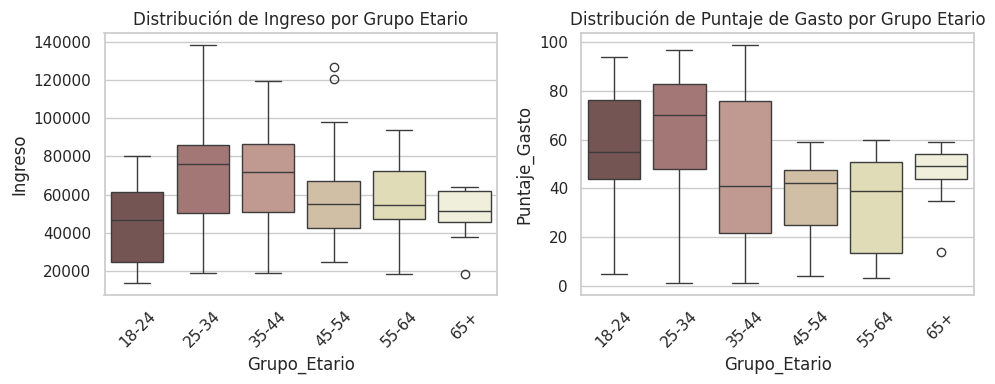

In [7]:
# Gráficas de estadísticas descriptivas por grupo etario
# Crear grupos etarios
bins = [0, 24, 34, 44, 54, 64, np.inf]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
df_filtered['Grupo_Etario'] = pd.cut(df_filtered['Edad'], bins=bins, labels=labels)

# Gráficas de estadísticas descriptivas por grupo etario
plt.figure(figsize=(10, 4))

# Ingreso por Grupo Etario
plt.subplot(1, 2, 1)
sns.boxplot(x='Grupo_Etario', y='Ingreso', data=df_filtered, hue='Grupo_Etario', palette="pink", legend=False)
plt.title('Distribución de Ingreso por Grupo Etario')
plt.xticks(rotation=45)

# Puntaje de Gasto por Grupo Etario
plt.subplot(1, 2, 2)
sns.boxplot(x='Grupo_Etario', y='Puntaje_Gasto', data=df_filtered, hue='Grupo_Etario', palette="pink", legend=False)
plt.title('Distribución de Puntaje de Gasto por Grupo Etario')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [8]:
# Agrupar por grupo etaria y calcular las estadísticas descriptivas
desc_stats_grupet = df_filtered.groupby('Grupo_Etario').describe()
desc_stats_grupet.T

Grupo_Etario                18-24          25-34          35-44  \
Edad          count     35.000000      54.000000      42.000000   
              mean      20.828571      30.092593      38.333333   
              std        1.992423       2.534803       2.825551   
              min       18.000000      25.000000      35.000000   
              25%       19.000000      28.000000      36.000000   
              50%       21.000000      30.500000      38.000000   
              75%       23.000000      32.000000      40.000000   
              max       24.000000      34.000000      44.000000   
Ingreso       count     35.000000      54.000000      42.000000   
              mean   44454.795429   71157.328148   66957.096905   
              std    20378.208373   27885.788157   27722.049259   
              min    13458.020000   19003.520000   18797.160000   
              25%    24465.320000   50141.657500   50771.222500   
              50%    46455.340000   75824.910000   71638.860000   
              75%    61564.355000   85872.937500   86762.775000   
              max    80360.650000  138584.520000  119534.680000   
Puntaje_Gasto count     35.000000      54.000000      42.000000   
              mean      56.257143      63.166667      49.428571   
              std       24.659258      24.283506      30.700078   
              min        5.000000       1.000000       1.000000   
              25%       44.000000      47.750000      21.500000   
              50%       55.000000      70.000000      41.000000   
              75%       76.500000      82.750000      75.750000   
              max       94.000000      97.000000      99.000000   

Grupo_Etario                 45-54         55-64           65+  
Edad          count      39.000000     16.000000     14.000000  
              mean       49.128205     59.187500     67.357143  
              std         2.647536      2.509150      1.598420  
              min        45.000000     55.000000     65.000000  
              25%        47.000000     57.750000     66.250000  
              50%        49.000000     59.000000     67.000000  
              75%        50.500000     60.000000     68.000000  
              max        54.000000     64.000000     70.000000  
Ingreso       count      39.000000     16.000000     14.000000  
              mean    58786.491026  56357.093125  51420.789286  
              std     24276.268114  22351.828240  12686.437083  
              min     24402.320000  18434.740000  18437.210000  
              25%     42447.560000  46947.207500  45659.180000  
              50%     55041.390000  54718.180000  51546.645000  
              75%     67337.095000  72384.277500  61858.467500  
              max    126685.780000  94049.490000  64156.370000  
Puntaje_Gasto count      39.000000     16.000000     14.000000  
              mean       36.230769     32.312500     46.714286  
              std        16.261776     21.752299     11.431593  
              min         4.000000      3.000000     14.000000  
              25%        25.000000     13.250000     43.750000  
              50%        42.000000     39.000000     49.000000  
              75%        47.500000     51.000000     54.250000  
              max        59.000000     60.000000     59.000000

**Procedimiento**

Se obtuvieron los diagramas de cajas y bigotes de las variables ingreso y Puntaje_Gasto para los clientes agrupados por los grupos etarios proporcionados, y se obtuvieron las estadísticas descriptivas.

**Análisis**

- Respecto a los ingresos, los clientes con edades entre 18 y 24 años son quienes tienen los menores ingresos, en contraste con aquellos usuarios entre los 25 y 44 quienes tienen los ingresos más altos. Sin embargo, se observan unos valores atípicos de usuarios entre 45 y 54 años quienes también tienen un alto potencial económico. Los ingresos promedios de los grupos de 45-54, 55-64 y mayores a 65 son similares y están alrededor de 55.000 dolares.

- En cuanto al puntaje de gasto, aunque los usuarios con edades entre 18 y 24 años, poseen bajos ingresos, se encuentran como el segundo grupo etario que más recurrencia de compra tiene. El grupo etario entre 25 y 39 años son los clientes que más compras realizan y por ende, quienes tienen los puntajes de gasto más altos. Por otra parte, se tiene un rango intercuartilico más grande del grupo etario 35-44 por lo que se pueden encontrar clientes con distintas frecuencias de compra.

**Conclusiones**

- Tanto clientes hombres como mujeres tienen edades similares, siendo el grupo de los hombres levemente más viejo.
- Los hombres tienen ingresos levemente más altos que las mujeres, encontrando que hay personas del género masculino que tienen salarios atípicos.
- La diferencia más notable se observa en la variable de puntaje de gasto, donde se deduce que las mujeres al tener en su mayoria puntajes más altos, tienen mayor frecuencia en las compras, y pueden ser clientes potenciales en quienes concentrarse para las estrategias de marketing focalizadas.

#### Segmentación por grupo etario y género

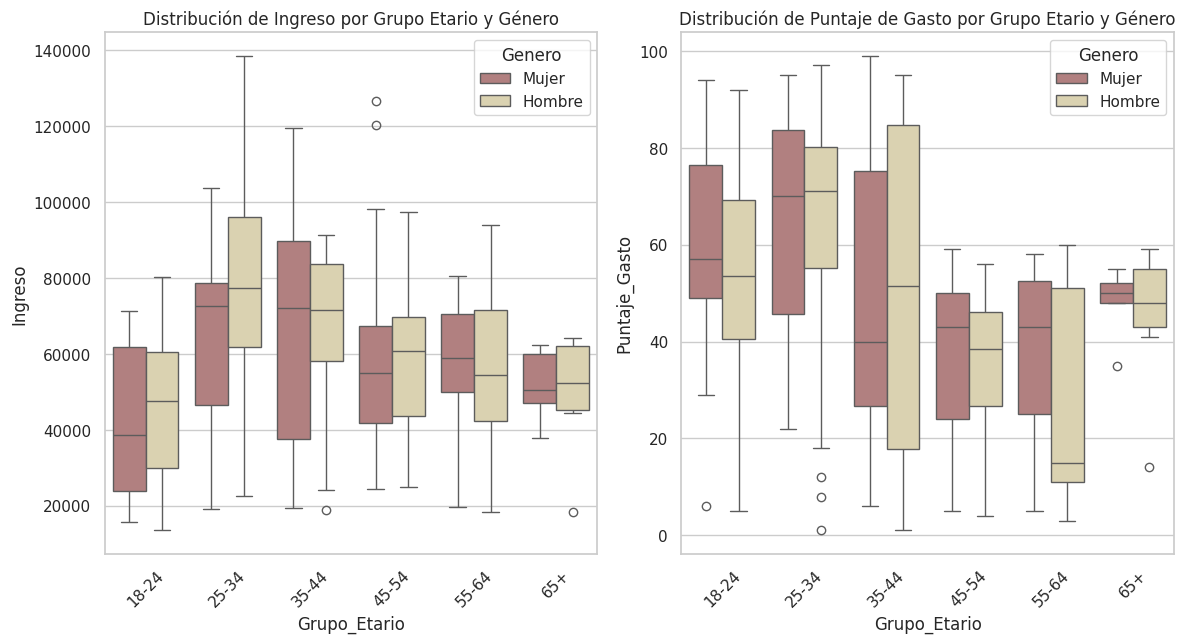

In [9]:
# Gráfica de Ingreso y Puntaje de Gasto por Grupo Etario y Género
plt.figure(figsize=(12, 12))

# Ingreso por Grupo Etario y Género
plt.subplot(2, 2, 1)
sns.boxplot(x='Grupo_Etario', y='Ingreso', hue='Genero', data=df_filtered, palette="pink")
plt.title('Distribución de Ingreso por Grupo Etario y Género')
plt.xticks(rotation=45)

# Puntaje de Gasto por Grupo Etario y Género
plt.subplot(2, 2, 2)
sns.boxplot(x='Grupo_Etario', y='Puntaje_Gasto', hue='Genero', data=df_filtered, palette="pink")
plt.title('Distribución de Puntaje de Gasto por Grupo Etario y Género')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Procedimiento, análisis y conclusiones

**Procedimiento**

Se obtuvieron los diagramas de cajas y bigotes de las variables ingreso y Puntaje_Gasto para los clientes agrupados por los grupos etarios proporcionados y género.
**Análisis**

- Respecto a los ingresos, en casi todos los grupos etarios, a excepción de 35-44, los hombres tienen mayores ingresos anuales que las mujeres. Sin embargo, las mujeres tienen un rango intercuartilico mas bajo y este se concentra hacia los mayores valores, lo que significa una menor variabilidad salarial.

- En cuanto al puntaje de gasto, las mujeres tienen patrones de recurrencia mayor a compras que los hombres en casi todos los grupos etarios, excepto de 35-44 años.

**Conclusiones**

- En casi todos los grupos etarios, a excepción de 35-44, los hombres tienen mayores ingresos anuales que las mujeres.
- Las mujeres tienen patrones de recurrencia mayor a compras que los hombres en casi todos los grupos etarios, excepto de 35-44 años.
- Por lo anterior, el grupo etario de 35-44 años parece tener un patrón diferente a los otros grupos, por lo que las estrategias de marketing deben ser cuidadosas cuando se apliquen a este subconjunto.

In [10]:
# Pruebas estadísticas
print("Prueba T para Ingresos por Género")
if len(df_filtered[df_filtered['Genero'] == 'Hombre']) > 0 and len(df_filtered[df_filtered['Genero'] == 'Mujer']) > 0:
    hombres_ingreso = df_filtered[df_filtered['Genero'] == 'Hombre']['Ingreso']
    mujeres_ingreso = df_filtered[df_filtered['Genero'] == 'Mujer']['Ingreso']
    t_stat, p_val = stats.ttest_ind(hombres_ingreso, mujeres_ingreso, equal_var=False)
    print(f"Estadística t: {t_stat}, p-valor: {p_val}")
else:
    print("No hay suficientes datos para realizar la prueba t para ingresos por género.")

print("\n")

print("Prueba T para Puntajes de Gasto por Género")
if len(df_filtered[df_filtered['Genero'] == 'Hombre']) > 0 and len(df_filtered[df_filtered['Genero'] == 'Mujer']) > 0:
    hombres_puntaje = df_filtered[df_filtered['Genero'] == 'Hombre']['Puntaje_Gasto']
    mujeres_puntaje = df_filtered[df_filtered['Genero'] == 'Mujer']['Puntaje_Gasto']
    t_stat, p_val = stats.ttest_ind(hombres_puntaje, mujeres_puntaje, equal_var=False)
    print(f"Estadística t: {t_stat}, p-valor: {p_val}")
else:
    print("No hay suficientes datos para realizar la prueba t para puntajes de gasto por género.")

print("\n")

# ANOVA para Ingresos por Grupo Etario
anova_ingreso = stats.f_oneway(*[group['Ingreso'].dropna() for name, group in df_filtered.groupby('Grupo_Etario')])
print("ANOVA para Ingresos por Grupo Etario")
print(f"Estadística F: {anova_ingreso.statistic:.4f}, p-valor: {anova_ingreso.pvalue:.4f}")

# ANOVA para Puntajes de Gasto por Grupo Etario
anova_puntaje = stats.f_oneway(*[group['Puntaje_Gasto'].dropna() for name, group in df_filtered.groupby('Grupo_Etario')])
print("\nANOVA para Puntajes de Gasto por Grupo Etario y genero")
print(f"Estadística F: {anova_puntaje.statistic:.4f}, p-valor: {anova_puntaje.pvalue:.4f}")


Prueba T para Ingresos por Género
Estadística t: 0.7133855872801346, p-valor: 0.4765105049312677


Prueba T para Puntajes de Gasto por Género
Estadística t: -0.8048781809684525, p-valor: 0.42199772447783646


ANOVA para Ingresos por Grupo Etario
Estadística F: 6.0197, p-valor: 0.0000

ANOVA para Puntajes de Gasto por Grupo Etario y genero
Estadística F: 8.2583, p-valor: 0.0000


**Procedimiento**

Para analizar si las diferencias observadas entre grupos son estadísticamente significativas se utiliza la prueba T, la cual es ampliamente utilizadas para comparar las medias de dos grupos independientes. Para comparar varios grupos, se utilizó ANOVA.

**Análisis**
- En cuanto a los ingresos anuales entre hombres y mujeres. La estadística t obtenida es 0.7134, lo que indica que la diferencia en los ingresos entre los dos géneros no es muy pronunciada. El p-valor de 0.4765 es significativamente mayor que el umbral común de significancia (0.05). Esto indica que no hay una diferencia estadísticamente significativa en los ingresos entre hombres y mujeres.

- Para los Puntajes de Gasto, la estadística t obtenida es -0.8049, lo que sugiere una pequeña diferencia en los puntajes de gasto entre géneros. El p-valor de 0.4220, al igual que en el caso de los ingresos, es mayor que 0.05. Esto implica que no hay una diferencia estadísticamente significativa en los puntajes de gasto entre los géneros.

-  Los resultados de las estadísticas F indica que hay una diferencia notable en los ingresos y Puntajes de gasto entre los diferentes grupos etarios. Además, los p-value sugieren que estas diferencias entre los grupos son altamente significativas desde el punto de vista estadístico.

**Conclusiones**
- Los resultados de las pruebas T sugieren que, no existen diferencias estadísticamente significativas en los ingresos y los puntajes de gasto entre hombres y mujeres. Esto implica que cualquier variación observada en estos aspectos puede deberse al azar y no a un patrón sistemático relacionado con el género.

- Al contrario de lo que ocurre con el genero, si hay evidencia estadísticamente significativa para afirmar que los puntajes de gasto varían entre los diferentes grupos etarios. Esto sugiere que la frecuencia de compra o el comportamiento de gasto está asociado con el grupo etario al que pertenece el cliente, y debe considerarse para la planeación de las estrategias de marketing.



### 3.Clustering Jerárquico

#### 3.1. Dendrogramas

Agrupe a los clientes utilizando sólo dos variables: su ingreso y el puntaje de gastos. Para ello retenga estas dos variables, estandarízelas, construya y grafique un dendograma. Para la construcción del dendrograma utilice el enlace 'ward' y la distancia euclidiana. Explique la importancia de estandarizar los datos.

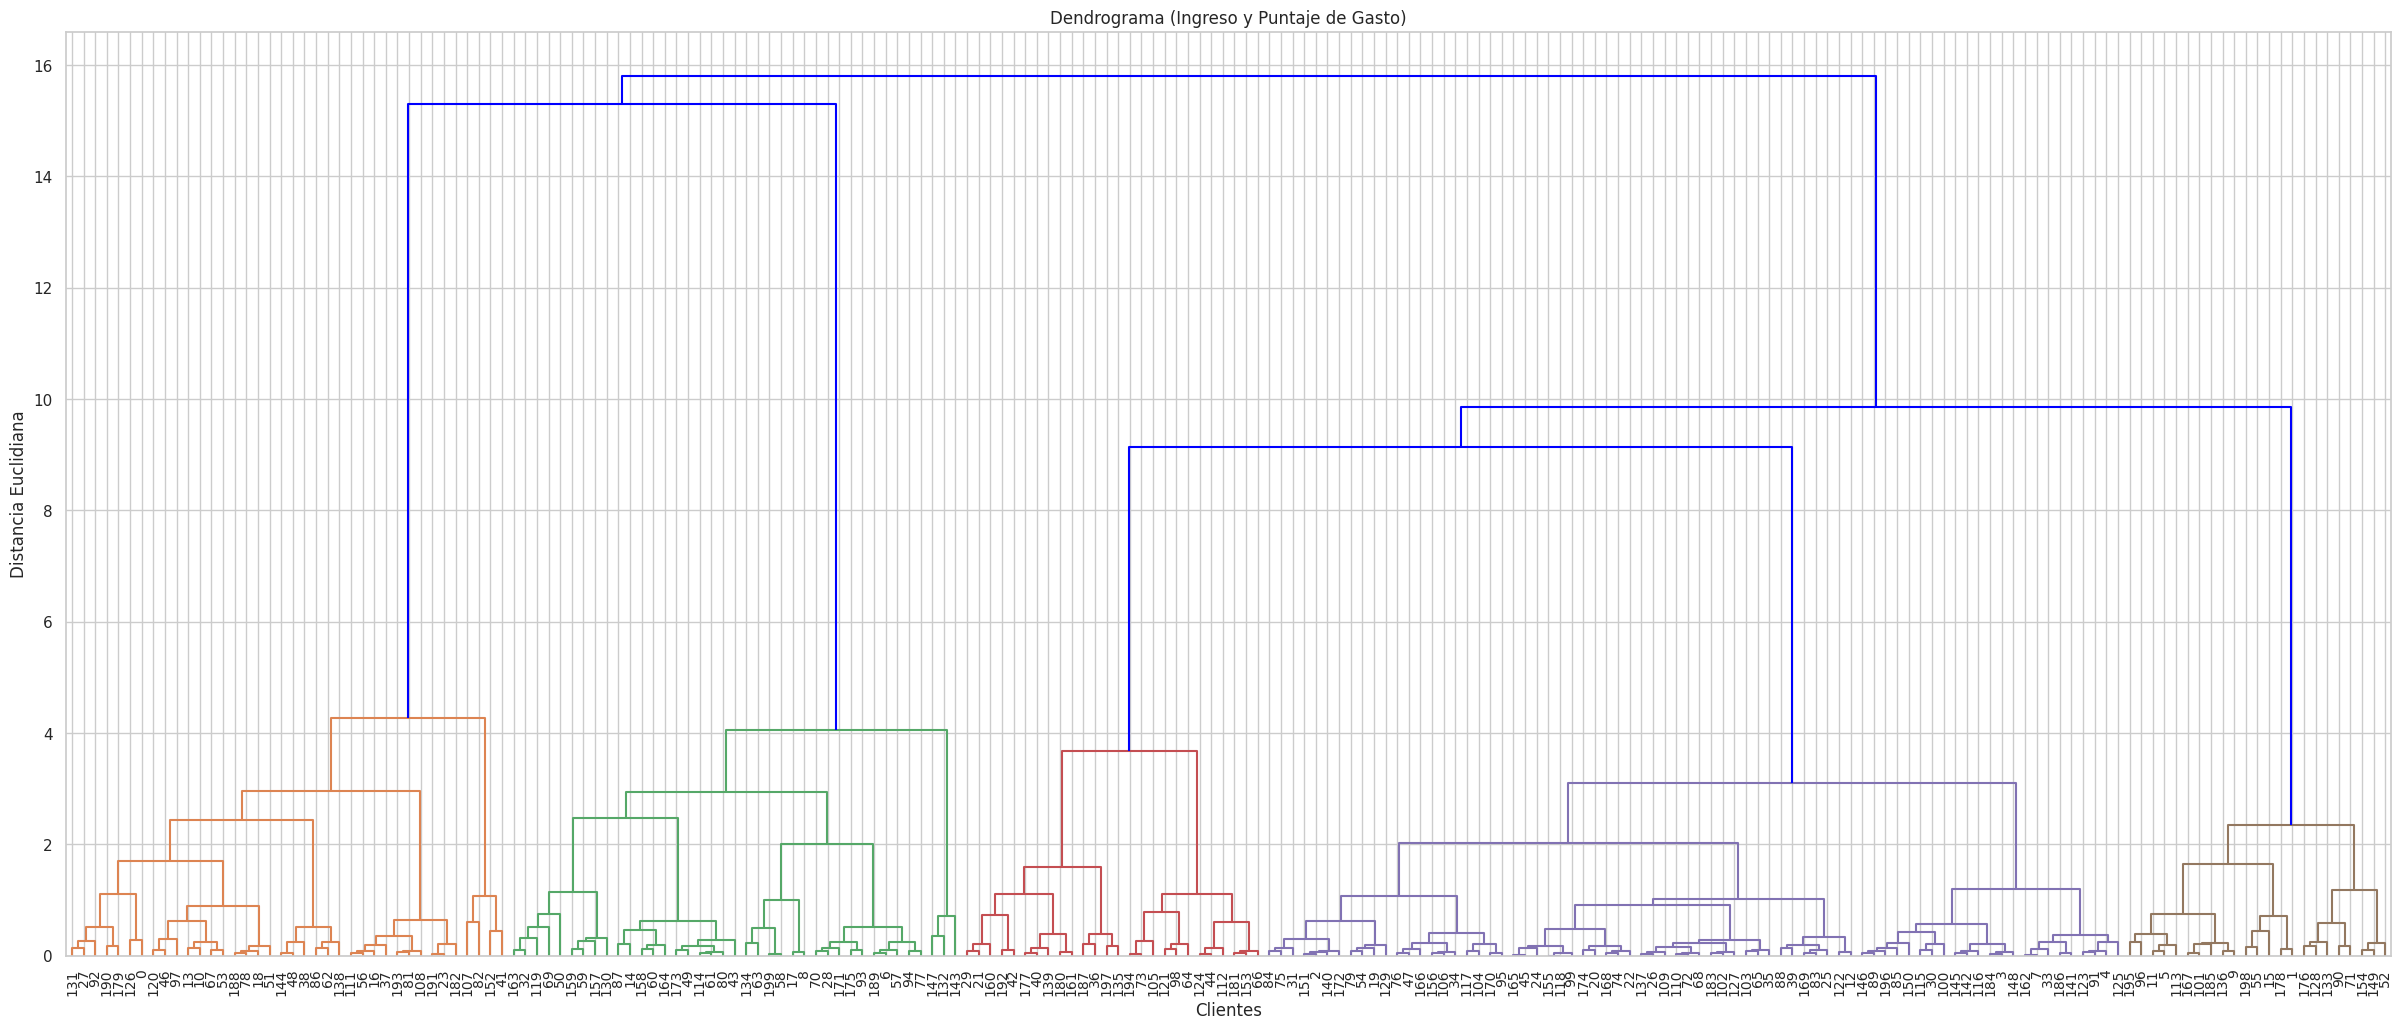

In [11]:
# Seleccionar las variables 'Ingreso' y 'Puntaje_Gasto'
variables = df[['Ingreso', 'Puntaje_Gasto']]

# Estandarizar las variables
scaler = StandardScaler()
variables_scaled = scaler.fit_transform(variables)

# Realizar el clustering jerárquico usando distancia euclidiana (predeterminada) y el método ward
linked = linkage(variables_scaled, method='ward')

# Graficar el dendrograma
plt.figure(figsize=(30, 12))
dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=False,
    leaf_rotation=90.,
    leaf_font_size=10.,
    color_threshold=6,
    above_threshold_color='blue'
    )

plt.title('Dendrograma (Ingreso y Puntaje de Gasto)')
plt.xlabel('Clientes')
plt.ylabel('Distancia Euclidiana')
plt.show()

**Procedimiento**

Inicialmente, se seleccionaron las dos variables solicitadas (Ingreso y Puntaje de Gasto), posteriormente se estandarizaron las variables, y se alicó el método de clustering jerárquico utilizando el enlace 'ward' y la distancia euclidiana, la cual está predeterminada.  Finalmente, se obtiene el dendrograma.

**Análisis y conclusiones**

Se puede observar en el dendograma que al considerar una distancia mayor a 4.2 y 8.5, se tienen 4 clusters principales, sin embargo, el número de clústeres depende del nivel en el que se realice el corte en la altura de las ramas.

**Importancia de la estandarización**

Es importante la estandarización, ya que cuando se realiza los cálculos de la distancia, si no están estandarizadas, posiblemente, aquellas variables con valores más altos son las que dominaran la agrupación de los datos. Por ejemplo, en este caso, Ingreso seguramente influirá de manera desproporcionada en el resultado del clustering por lo que clientes con ingresos muy altos podrían ser agrupados juntos, independientemente de su comportamiento de gasto. Esto puede llevar a resultados distorsionados que no reflejan adecuadamente la verdadera similitud entre los clientes y que no se puedan realizar estrategias de marketing efectivas.

#### 3.2. Número de clusters

Retenga el número de clusters que se obtengan luego de fijar la distancia en 6.

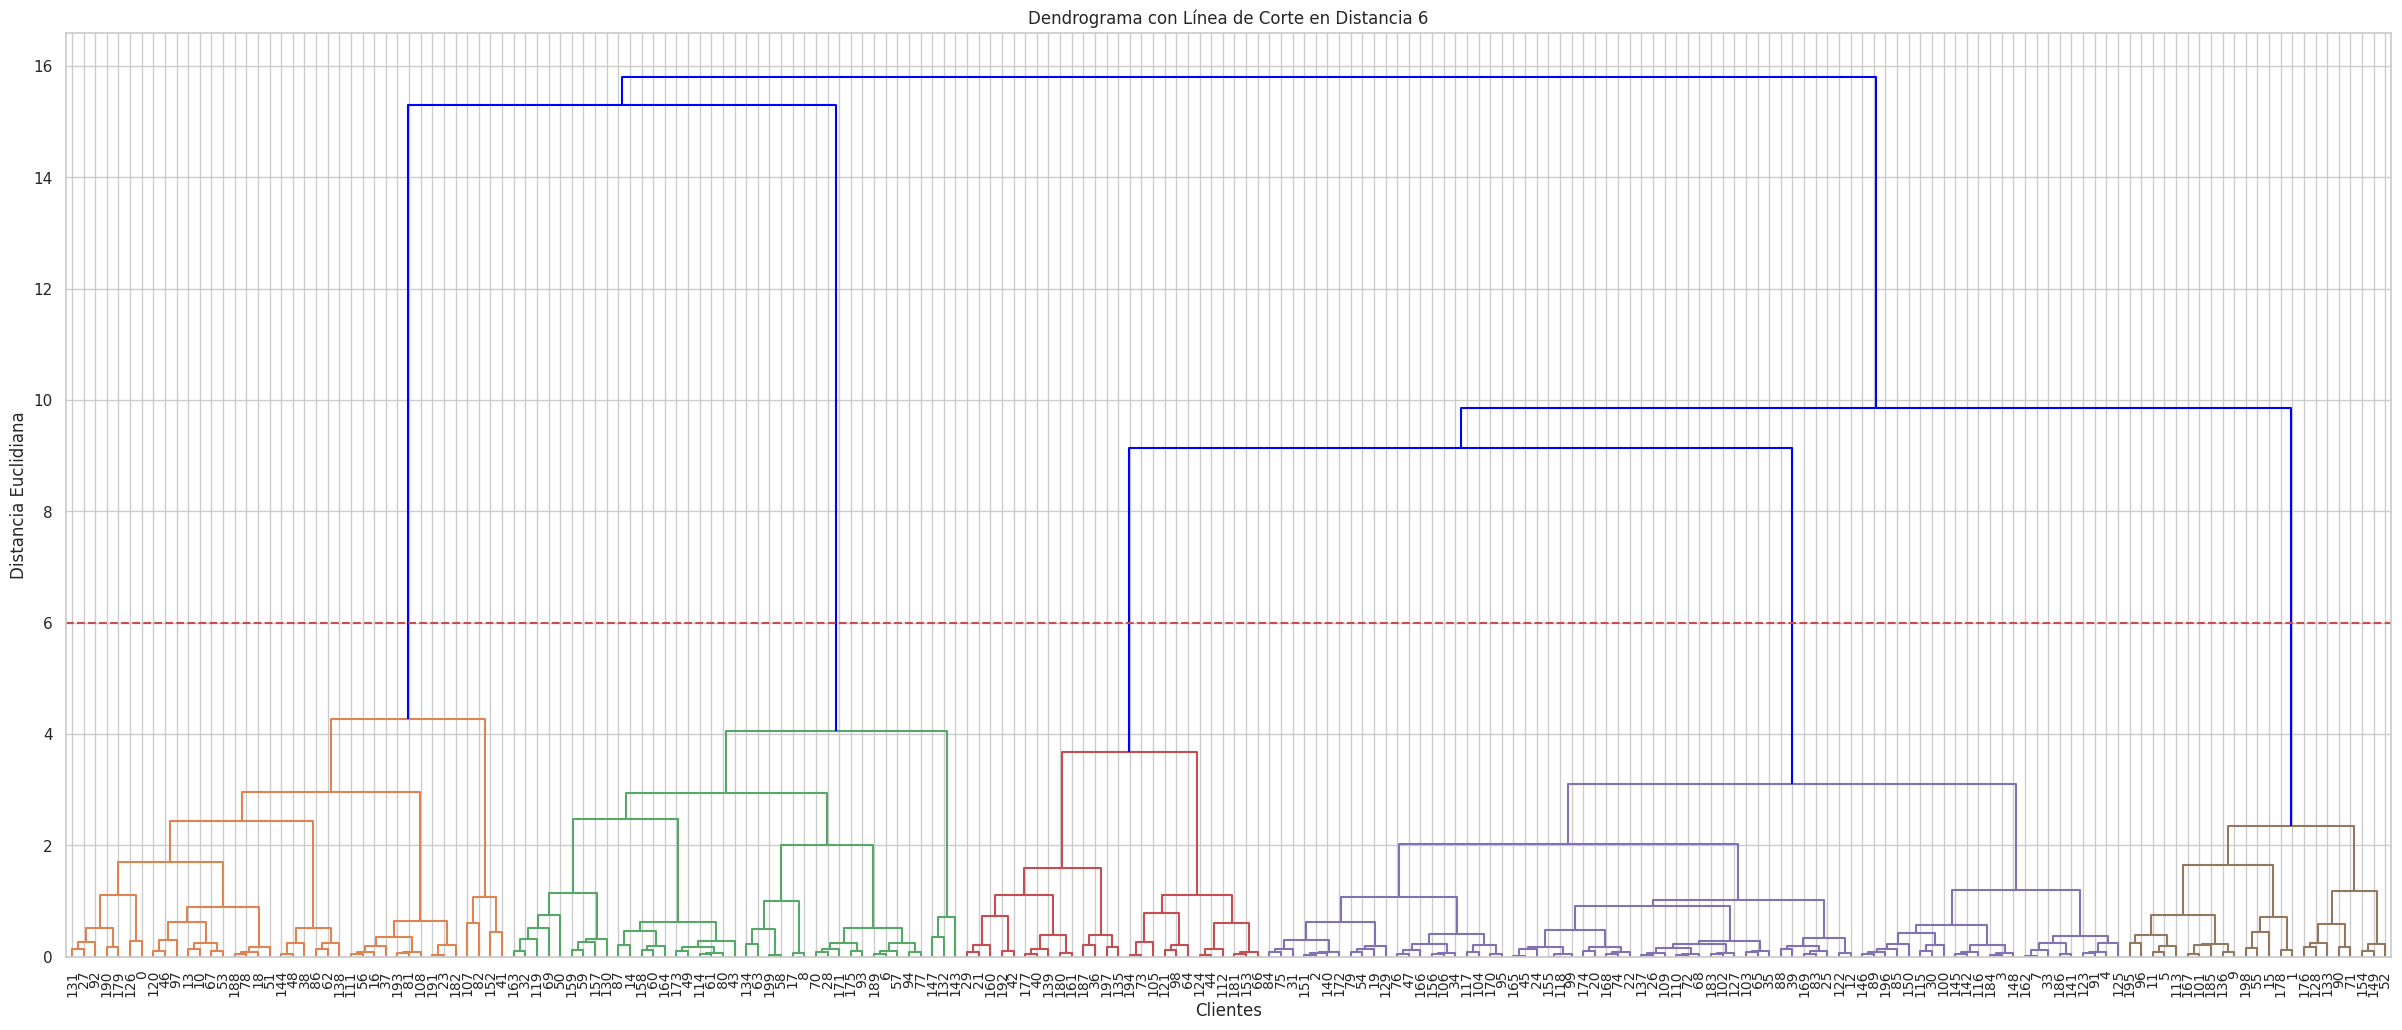

Al realizar el corte del dendograma con una distancia euclidiana de 6, se forman 5 clusters.


In [12]:
# Retener los clusters formados al fijar la distancia en 6
clusters = fcluster(linked, t=6, criterion='distance')

# Graficar el dendrograma
plt.figure(figsize=(30, 12))  # Ajustar el tamaño del gráfico
dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=False,
    leaf_rotation=90.,
    leaf_font_size=10.,
    color_threshold=6,
    above_threshold_color='blue'
)

plt.axhline(y=6, color='r', linestyle='--')

plt.title('Dendrograma con Línea de Corte en Distancia 6')
plt.xlabel('Clientes')
plt.ylabel('Distancia Euclidiana')
plt.show()

# Contar el número de clusters formados
print(f"Al realizar el corte del dendograma con una distancia euclidiana de 6, se forman {len(set(clusters))} clusters.")

**Procedimiento**

Inicialmente, se utiliza la funcion fcluster para retener los clusters formados con corte a una distancia de 6. Luego, se vuelve a graficar el dendograma del punto anterior y se corrobora visualmente el número de clusters formados.

**Análisis y conclusiones**

Se puede observar en el dendograma que al considerar una distancia de corte de 6, se retienen 5 clúster, donde el cluster morado es el que agrupa más clientes, mientras que el cluster gris es el que contiene al parecer menos clientes.

#### 3.3. Algoritmo Jerárquico Aglomerativo

Utilizando el número de clusters encontrados en el paso anterior, aplique el algoritmo jerárquico aglomerativo, utilizando el enlace 'ward' y la distancia euclidiana. Describa los grupos encontrados, en que grupo o grupos concentraría su estrategia de marketing y por qué?

In [13]:
# Aplicar el algoritmo jerárquico aglomerativo con 5 clusters
agg_clustering = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
df_agg = df.copy()
df_agg['Cluster_Agg'] = agg_clustering.fit_predict(variables_scaled)

In [14]:
# Obtención de estadísticas descriptivas
df_filtered2 = df_agg.drop(columns=['Id_Cliente'])
desc_stats_clust5 = df_filtered2.groupby('Cluster_Agg').describe()
desc_stats_clust5.T

Cluster_Agg                      0             1              2             3  \
Edad          count      38.000000     26.000000      39.000000     23.000000   
              mean       40.394737     44.115385      32.692308     25.521739   
              std        11.376931     13.094509       3.728650      5.273170   
              min        19.000000     19.000000      27.000000     18.000000   
              25%        34.000000     35.000000      30.000000     21.500000   
              50%        41.500000     45.500000      32.000000     24.000000   
              75%        47.000000     52.750000      35.500000     30.000000   
              max        59.000000     67.000000      40.000000     35.000000   
Ingreso       count      38.000000     26.000000      39.000000     23.000000   
              mean    87055.074474  28274.667308   86537.496410  26230.419565   
              std     16200.102296   8998.503308   16684.184918   7742.413865   
              min     70888.720000  13458.020000   68486.790000  15766.840000   
              25%     75765.510000  19362.520000   75875.515000  19590.810000   
              50%     80570.395000  28787.940000   77996.300000  24905.790000   
              75%     95988.570000  37203.277500   93952.440000  33157.710000   
              max    138584.520000  43155.280000  137838.570000  38950.660000   
Puntaje_Gasto count      38.000000     26.000000      39.000000     23.000000   
              mean       18.631579     23.307692      82.128205     78.565217   
              std        10.915947     13.959281       9.364489     10.953729   
              min         1.000000      3.000000      63.000000     61.000000   
              25%        10.250000     13.250000      74.500000     73.000000   
              50%        16.500000     27.000000      83.000000     77.000000   
              75%        26.750000     35.000000      90.000000     84.500000   
              max        40.000000     42.000000      97.000000     99.000000   

Cluster_Agg                     4  
Edad          count     74.000000  
              mean      43.594595  
              std       16.787894  
              min       18.000000  
              25%       27.000000  
              50%       47.500000  
              75%       56.500000  
              max       70.000000  
Ingreso       count     74.000000  
              mean   55451.258514  
              std     7847.567060  
              min    40218.680000  
              25%    48594.107500  
              50%    57359.505000  
              75%    61796.637500  
              max    70469.660000  
Puntaje_Gasto count     74.000000  
              mean      50.216216  
              std        5.871385  
              min       40.000000  
              25%       46.000000  
              50%       50.000000  
              75%       55.000000  
              max       60.000000

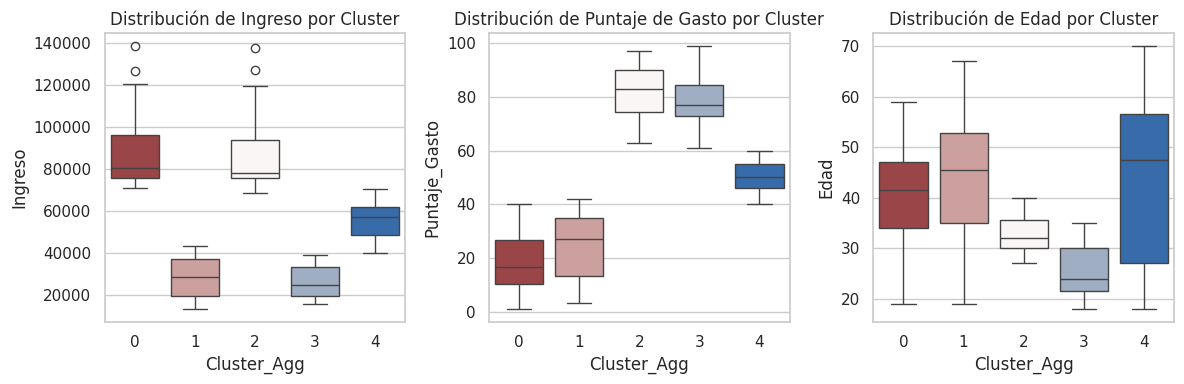

In [15]:
def boxplots_clusters(df, nombre_col):
  # Configuración de estilo para las gráficas
  sns.set(style="whitegrid")

  # Gráficas de estadísticas descriptivas por género
  plt.figure(figsize=(12, 4))

  # Ingreso de acuerdo a cada cluster
  plt.subplot(1, 3, 1)
  sns.boxplot(x=nombre_col, y='Ingreso', data=df, hue=nombre_col, palette="vlag_r", legend=False)
  plt.title('Distribución de Ingreso por Cluster')

  # Puntaje de acuerdo a cada cluster
  plt.subplot(1, 3, 2)
  sns.boxplot(x=nombre_col, y='Puntaje_Gasto', data=df, hue=nombre_col, palette="vlag_r", legend=False)
  plt.title('Distribución de Puntaje de Gasto por Cluster')

  # Edad de acuerdo a cada cluster
  plt.subplot(1, 3, 3)
  sns.boxplot(x=nombre_col, y='Edad', data=df, hue=nombre_col, palette="vlag_r", legend=False)
  plt.title('Distribución de Edad por Cluster')

  plt.tight_layout()
  plt.show()

boxplots_clusters(df_agg, 'Cluster_Agg')

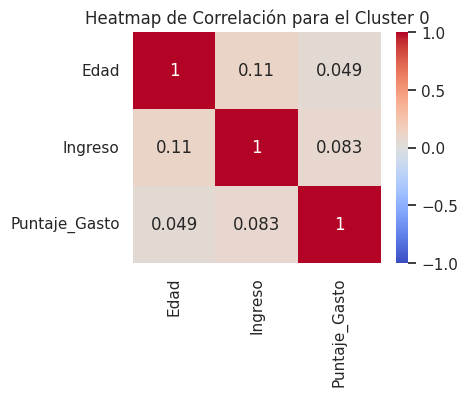

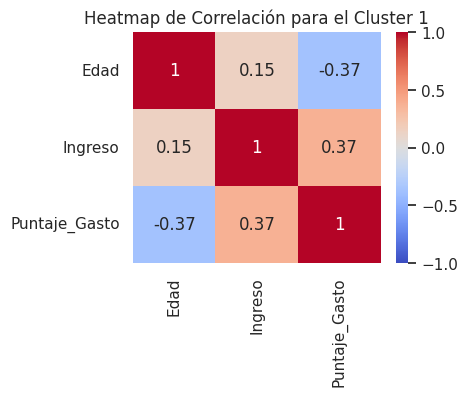

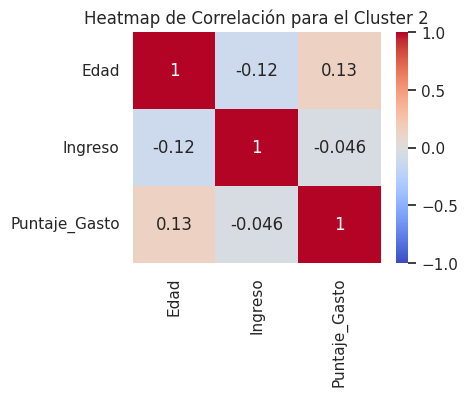

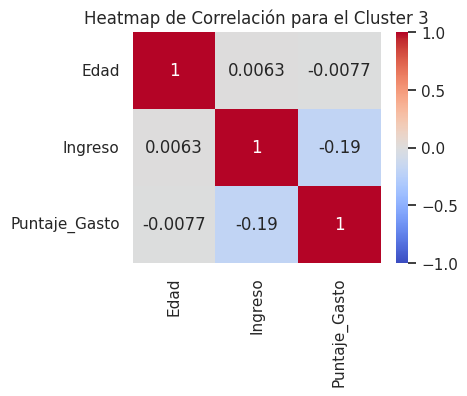

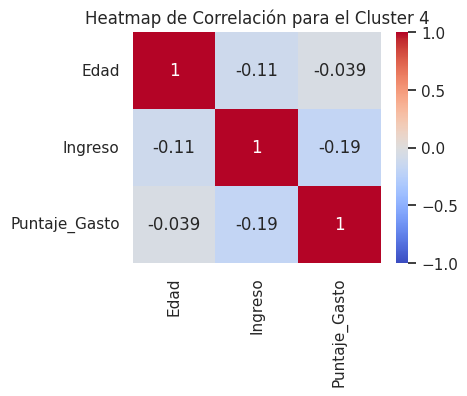

In [16]:
for cluster in range(0,5):
    cluster_data = df_agg[df_agg['Cluster_Agg'] == cluster]
    corr_matrix = cluster_data[['Edad', 'Ingreso', 'Puntaje_Gasto']].corr()
    plt.figure(figsize=(4, 3))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Heatmap de Correlación para el Cluster {cluster}')
    plt.show()

#### Procedimiento, análisis y conclusiones

**Procedimiento**

Se aplicó el algoritmo jerárquico aglomerativo para los 5 cluster encontrados en el punto anterior, utilizando el enlace 'ward' y la distancia euclidiana. Posteriormente, se agrupó el df de acuerdo a los cluster y se obtuvieron las estadísticas descriptivas. También se calculo la matriz de correlación en cada cluster para identificar posibles patrones o relaciones entre Edad, Ingreso y Puntaje_Gasto que puedan servir como base para planear estrategias de marketing efectivas.

**Análisis**
- En el cluster 0 se agruparon principalmente personas con edades entre 35 y 48 años, las cuales tienen ingresos anuales altos, pero bajos puntajes de gastos.
- En el Cluster 1 se concentran clientes con edades entre 35 y 53 años, que no tienen ni puntajes de gastos ni ingresos anuales altos, lo que signfica que no es un grupo para el que sea interesante construir estrategias de marketing.
- El Cluster 2 tiene un rango de edades menos amplio que los otros cluster, variando en su mayoria entre 27 y 35 años, y tienen ingresos y puntajes de gastos altos, lo que lo hace altamente atractivo para el desarrollo de estrategias de marketing.
- El Cluster 3 agrupa principalmente a clientes jovenes, entre 21 y 35 años, los cuales presentan puntajes de gastos altos, pero bajos ingresos anuales.
- El Cluster 4 está conformado por clientes de distintas edades que exhiben ingresos y puntajes de gastos intermedios.

Por lo anterior, el Cluster 2 es el más atractivo para estrategias de marketing. La combinación de ingresos altos y puntajes de gastos elevados indica que estos clientes no solo tienen capacidad financiera, sino también un alto nivel de gasto en sus compras. Adicionalmente, es probable que estos clientes sean leales si se les ofrece un buen valor y experiencia, por lo que se puede ofrecer productos o servicios premium y exclusivos, así como programas de fidelización y promociones especiales. Sin embargo, se deberia tener cuidado puesto que la correlación entre ingreso y puntaje_gasto es levemente negativa, lo que indica que aquellos con ingresos más bajos en este grupo, son lo que tienen más tendencia al gasto y no se desea un sobreendeudamiento.

Otros clusters interesantes para aplicar estrategias de marketing son 0 y 4. Las características del cluster 0 indica que los clientes en este grupo no están gastando tanto como podrían. Por lo que se podrian diseñar estrategias para aumentar el gasto, como promociones específicas, ventas cruzadas, o mejoras en la experiencia de compra. A diferencia del cluster 2, no hay alguna consideración especial, ya que la correlación entre ingreso y Puntaje_Gasto es levemente positiva, por lo que estos clientes probablemente sean cuidadosos cuando gastan y esto disminuye la probabilidad de sobreendeudamiento. En cuanto al grupo 4, se podrían implementar estrategias de marketing más generales o diversificadas, ya que se tienen edades variadas, ingresos y puntajes de gasto intermedios.

**Conclusiones**
- Los clusters en los que se recomienda aplicar estrategias de Marketing son 0, 2 y 4. Especialmente, el Cluster 2,  ya que tienen ingresos anuales y puntajes de gastos altos, por lo que se podrian llevar a cabo estrategias de fidelización.
- Los Clusters 1 y 3 no presentan un potencial significativo para desarrollar estrategias de marketing, ya que podrian no ser rentables y su inversión podría desviar recursos que probablmenete sean más efectivos en otros clusters.


### 4.DBSCAN

Implemente DBSCAN, al igual que el punto anterior sólo dos variables: su ingreso y el puntaje de gastos. Al implementar  justifique su elección de `min_samples` y `eps`. ¿Cuántos grupos o clusters encuentra? ¿Cuáles son su características? ¿Cambiaría su estrategia de marketing respecto al punto anterior? Justifique su respuesta.

#### Selección de hiperparámetros

##### Eps

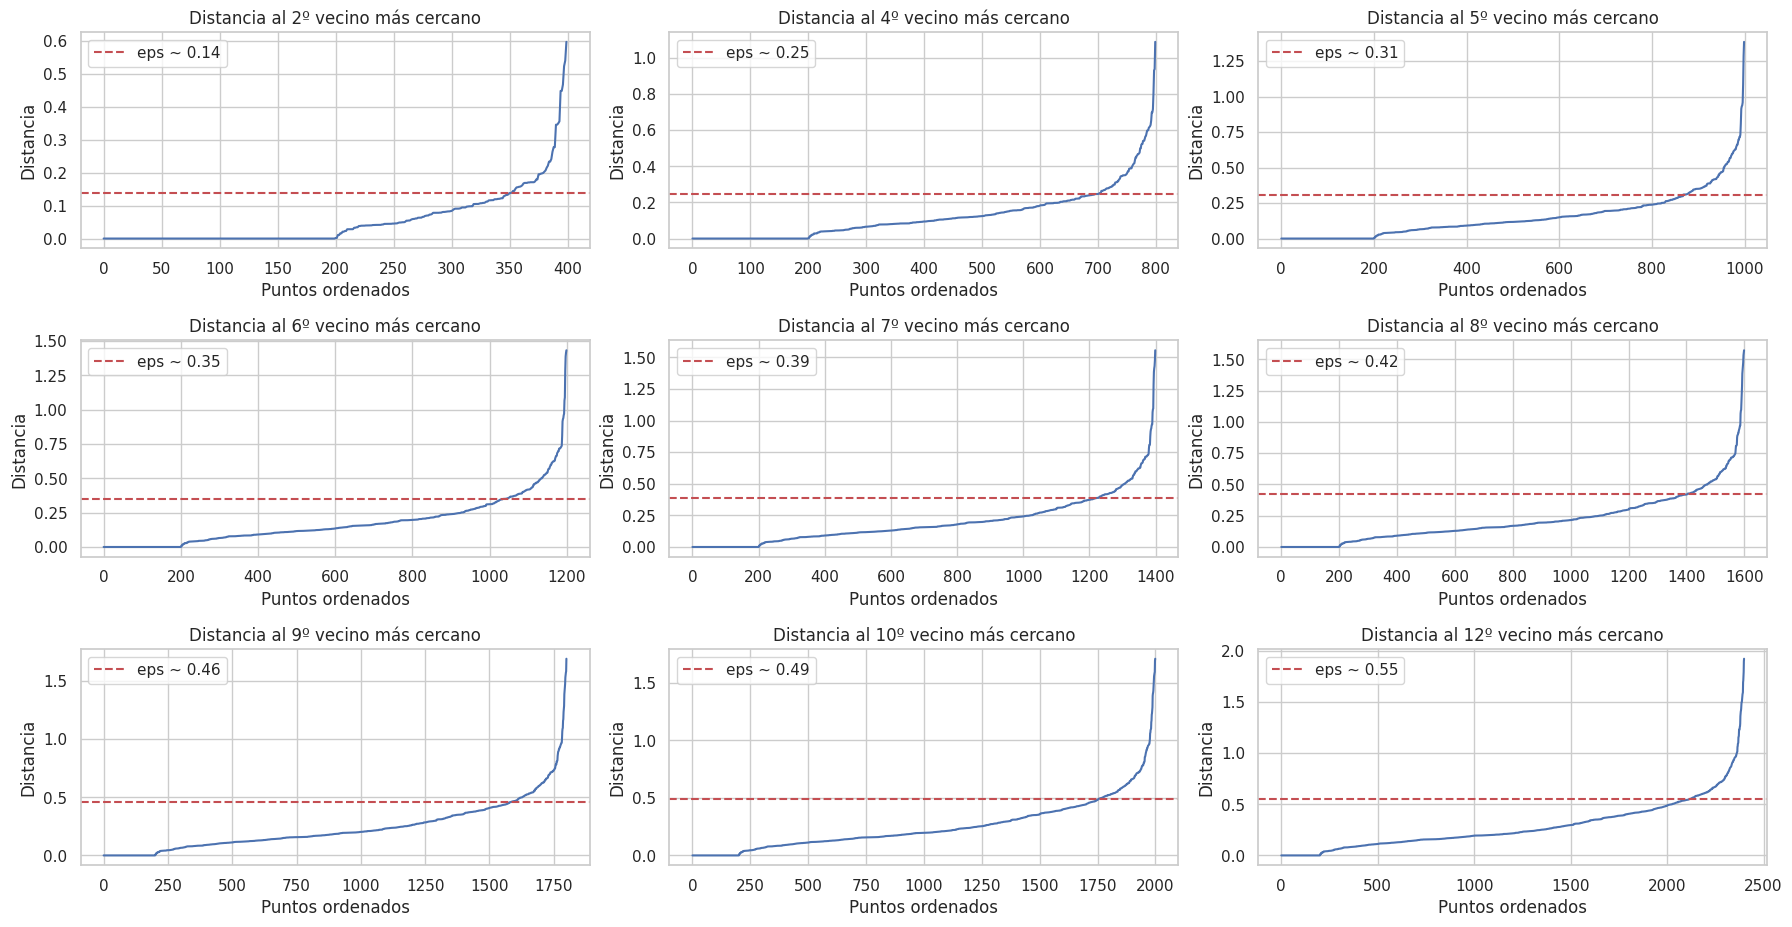

n_neighbors: 2, eps: 0.14, Number of clusters: 6
n_neighbors: 4, eps: 0.25, Number of clusters: 8
n_neighbors: 5, eps: 0.31, Number of clusters: 7
n_neighbors: 6, eps: 0.35, Number of clusters: 5
n_neighbors: 7, eps: 0.39, Number of clusters: 3
n_neighbors: 8, eps: 0.42, Number of clusters: 2
n_neighbors: 9, eps: 0.46, Number of clusters: 2
n_neighbors: 10, eps: 0.49, Number of clusters: 1
n_neighbors: 12, eps: 0.55, Number of clusters: 1


In [17]:
# Lista de valores de n_neighbors para experimentar
n_neighbors_list = [2, 4, 5, 6, 7, 8, 9, 10, 12]

# Lista para almacenar los valores de eps y el número de clusters calculados
eps_values = []
num_clusters = []

# Crear una figura para las subplots
plt.figure(figsize=(18, 12))

# Iterar sobre los valores de n_neighbors
for i, n_neighbors in enumerate(n_neighbors_list):
    # Ajustar el modelo NearestNeighbors para encontrar los n_neighbors más cercanos
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(variables_scaled)
    distancias, indices = nbrs.kneighbors(variables_scaled)

    # Ordenar las distancias
    distancias = np.sort(distancias.flatten())

    # Crear subplot
    plt.subplot(4, 3, i + 1)
    plt.plot(distancias)

    # Encontrar el punto de "codo" en la curva
    kneedle = KneeLocator(np.arange(len(distancias)), distancias, S=1, curve='convex', direction='increasing', interp_method='polynomial')

    # Almacenar el valor de eps
    eps_value = distancias[kneedle.knee]
    eps_values.append(eps_value)

    # Realizar el clustering DBSCAN con el valor de eps encontrado
    db = DBSCAN(eps=eps_value, min_samples=4).fit(variables_scaled)
    labels = db.labels_

    # Contar el número de clusters encontrados (excluyendo el ruido, que se etiqueta como -1)
    num_clusters_value = len(set(labels)) - (1 if -1 in labels else 0)
    num_clusters.append(num_clusters_value)

    # Trazar el punto del "codo"
    plt.axhline(y=eps_value, color='r', linestyle='--', label=f'eps ~ {distancias[kneedle.knee]:.2f}')
    plt.title(f'Distancia al {n_neighbors}º vecino más cercano')
    plt.xlabel('Puntos ordenados')
    plt.ylabel('Distancia')
    plt.legend()


plt.tight_layout()
plt.show()

# Imprimir los valores de eps y el número de clusters para referencia
for i, n_neighbors in enumerate(n_neighbors_list):
    print(f'n_neighbors: {n_neighbors}, eps: {eps_values[i]:.2f}, Number of clusters: {num_clusters[i]}')

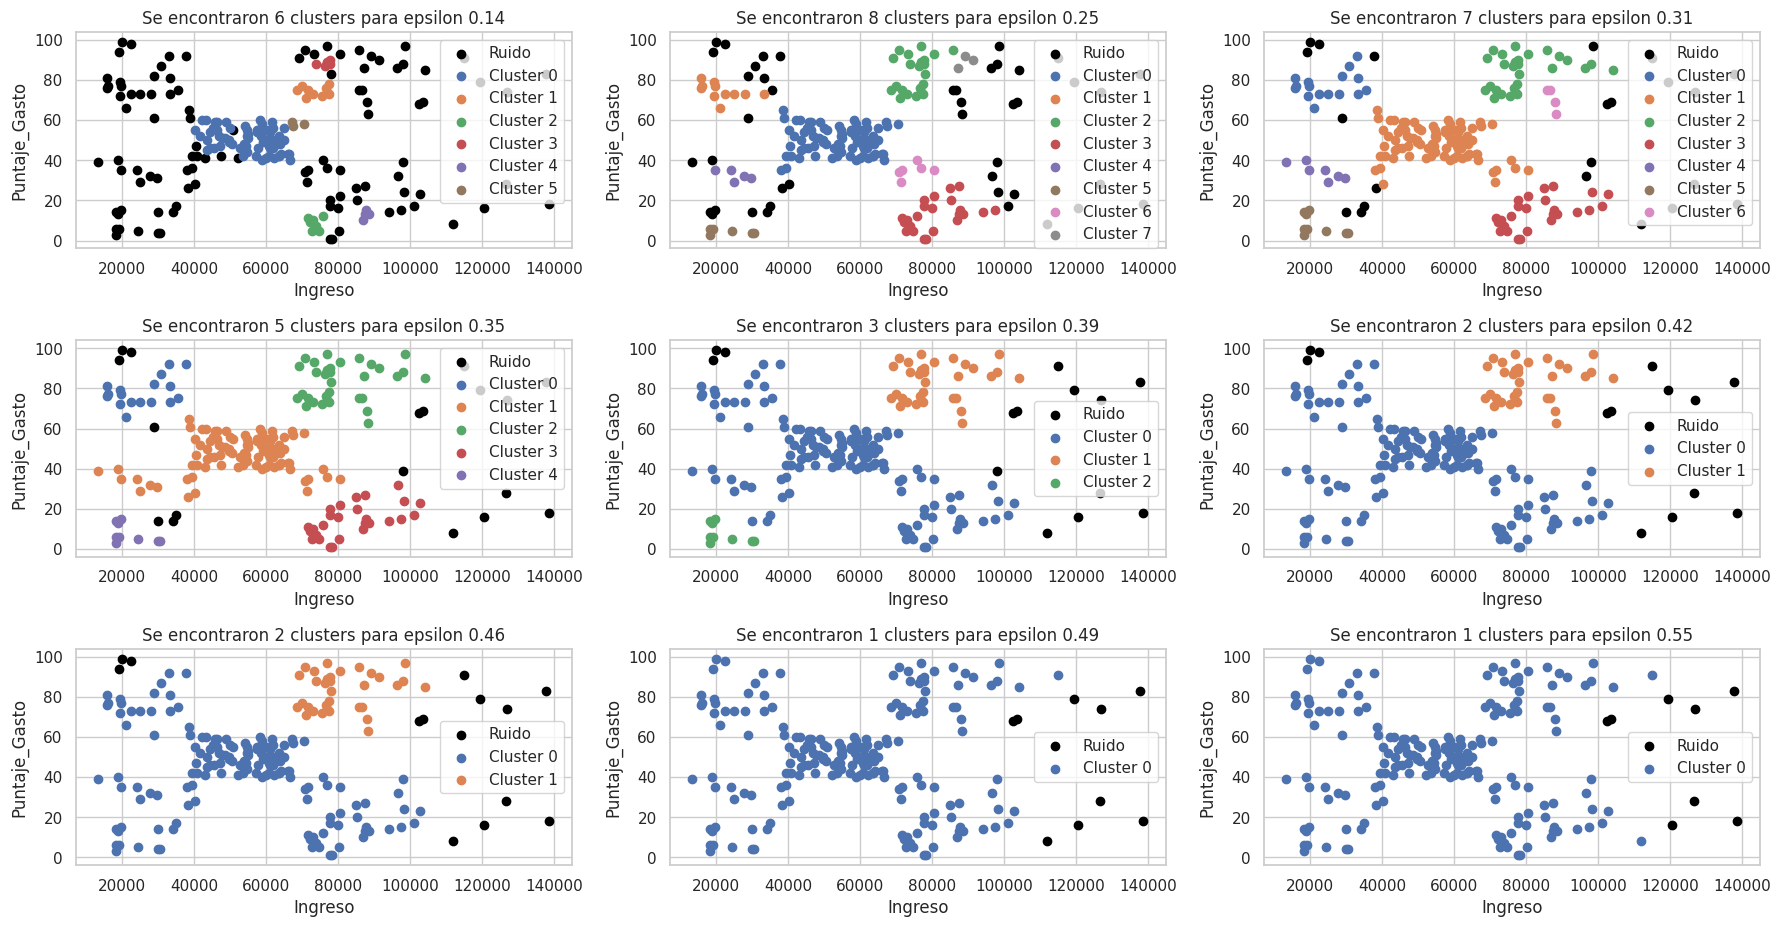

In [18]:
df_db = df.copy()

# Crear una figura para las subplots
plt.figure(figsize=(18, 12))

# Iterar sobre los valores de eps
for i, eps_f in enumerate(eps_values):
    # Ajustar el modelo DBSCAN con el valor de eps actual
    db2 = DBSCAN(eps=eps_f, min_samples=4).fit(variables_scaled)
    clusteres_db = db2 .labels_
    n_clusteres = len(set(clusteres_db)) - (1 if -1 in clusteres_db else 0)

    df_db['Cluster_db'] = clusteres_db

    # Crear un DataFrame con los resultados
    #resultado = pd.DataFrame(variables_scaled, columns=['Ingreso_stand', 'Puntaje_Gasto_stand']).assign(Cluster=clusteres_db)

    # Crear subplot para cada valor de eps
    plt.subplot(4, 3, i + 1)
    for k in np.unique(clusteres_db):
        if k != -1:
            plt.scatter(
                x=df_db.loc[df_db.Cluster_db == k, 'Ingreso'],
                y=df_db.loc[df_db.Cluster_db == k, 'Puntaje_Gasto'],
                label=f'Cluster {k}'
            )
        else:
            plt.scatter(
                x=df_db.loc[df_db.Cluster_db == k, 'Ingreso'],
                y=df_db.loc[df_db.Cluster_db == k, 'Puntaje_Gasto'],
                c='black',
                label='Ruido'
            )

    plt.title(f'Se encontraron {n_clusteres} clusters para epsilon {eps_f:.2f}')
    plt.xlabel('Ingreso')
    plt.ylabel('Puntaje_Gasto')
    plt.legend()

plt.tight_layout()
plt.show()

**Procedimiento**

Antes de la implementación final de DBSCAN, es importante definir los mejores parámetros para eps y min_samples.

Por lo que para la obtención del mejor valor de eps, se utilizó el método sugerido por Rahmah y Sukaesih (2012). Donde, se calcula la distancia a los `min_samples` más cercanos de cada punto y posteriormente se ordenan los resultados de menor a mayor. Luego se grafican los resultados y el valor óptimo de `eps` será el punto donde se encuentre la mayor curvatura en la gráfica. Para detectar facilmente este punto se utilizo la libreria kneed. Este proceso se realizó con varios valores de n_neighbors.

Posteriormente, se encontraron también el número de clusters formados a partir de cada valor de epsilon y se graficó la distribución de cada cluster en Ingreso vs Puntaje_Gasto de los mejores valores, para definir el valor de eps más adecuado. Todavia no se calibra el valor de min_samples, pero se definió en 4 ya que es el valor sugerido por Ester et al. (1996).

**Análisis**
- Se observa que con n_neighbors = 2, el número de cluster formados es 6, y con n_neighbors = 4 aumenta el número de cluster construidos, por lo que se establece que por debajo de 4 no se encuentra el valor óptimo de eps. Adicionalmente, con n_neighbors mayor o igual a 10 solo se forma 1 clúster, por lo tanto, se descartan valores de eps mayores a 0.49.
- Dado que eps óptimo podria estar entre 0.25 y 0.46, se graficó la distribución de los clusters.
- Se evidenció el eps más apropiado puede ser 0.31 o 0.35, ya que otros valores forman grupos pequeños o muy grandes que no son apropiados ni reflejan, al parecer, características importantes de los datos.

**Conclusiones**
- El eps óptimo  puede ser 0.31 o 0.35. Sin embargo, es necesario seleccionar el mejor valor de min_samples, por lo que se empleara la combinación de estos dos valores con distintos valores de min_samples.

##### min_samples

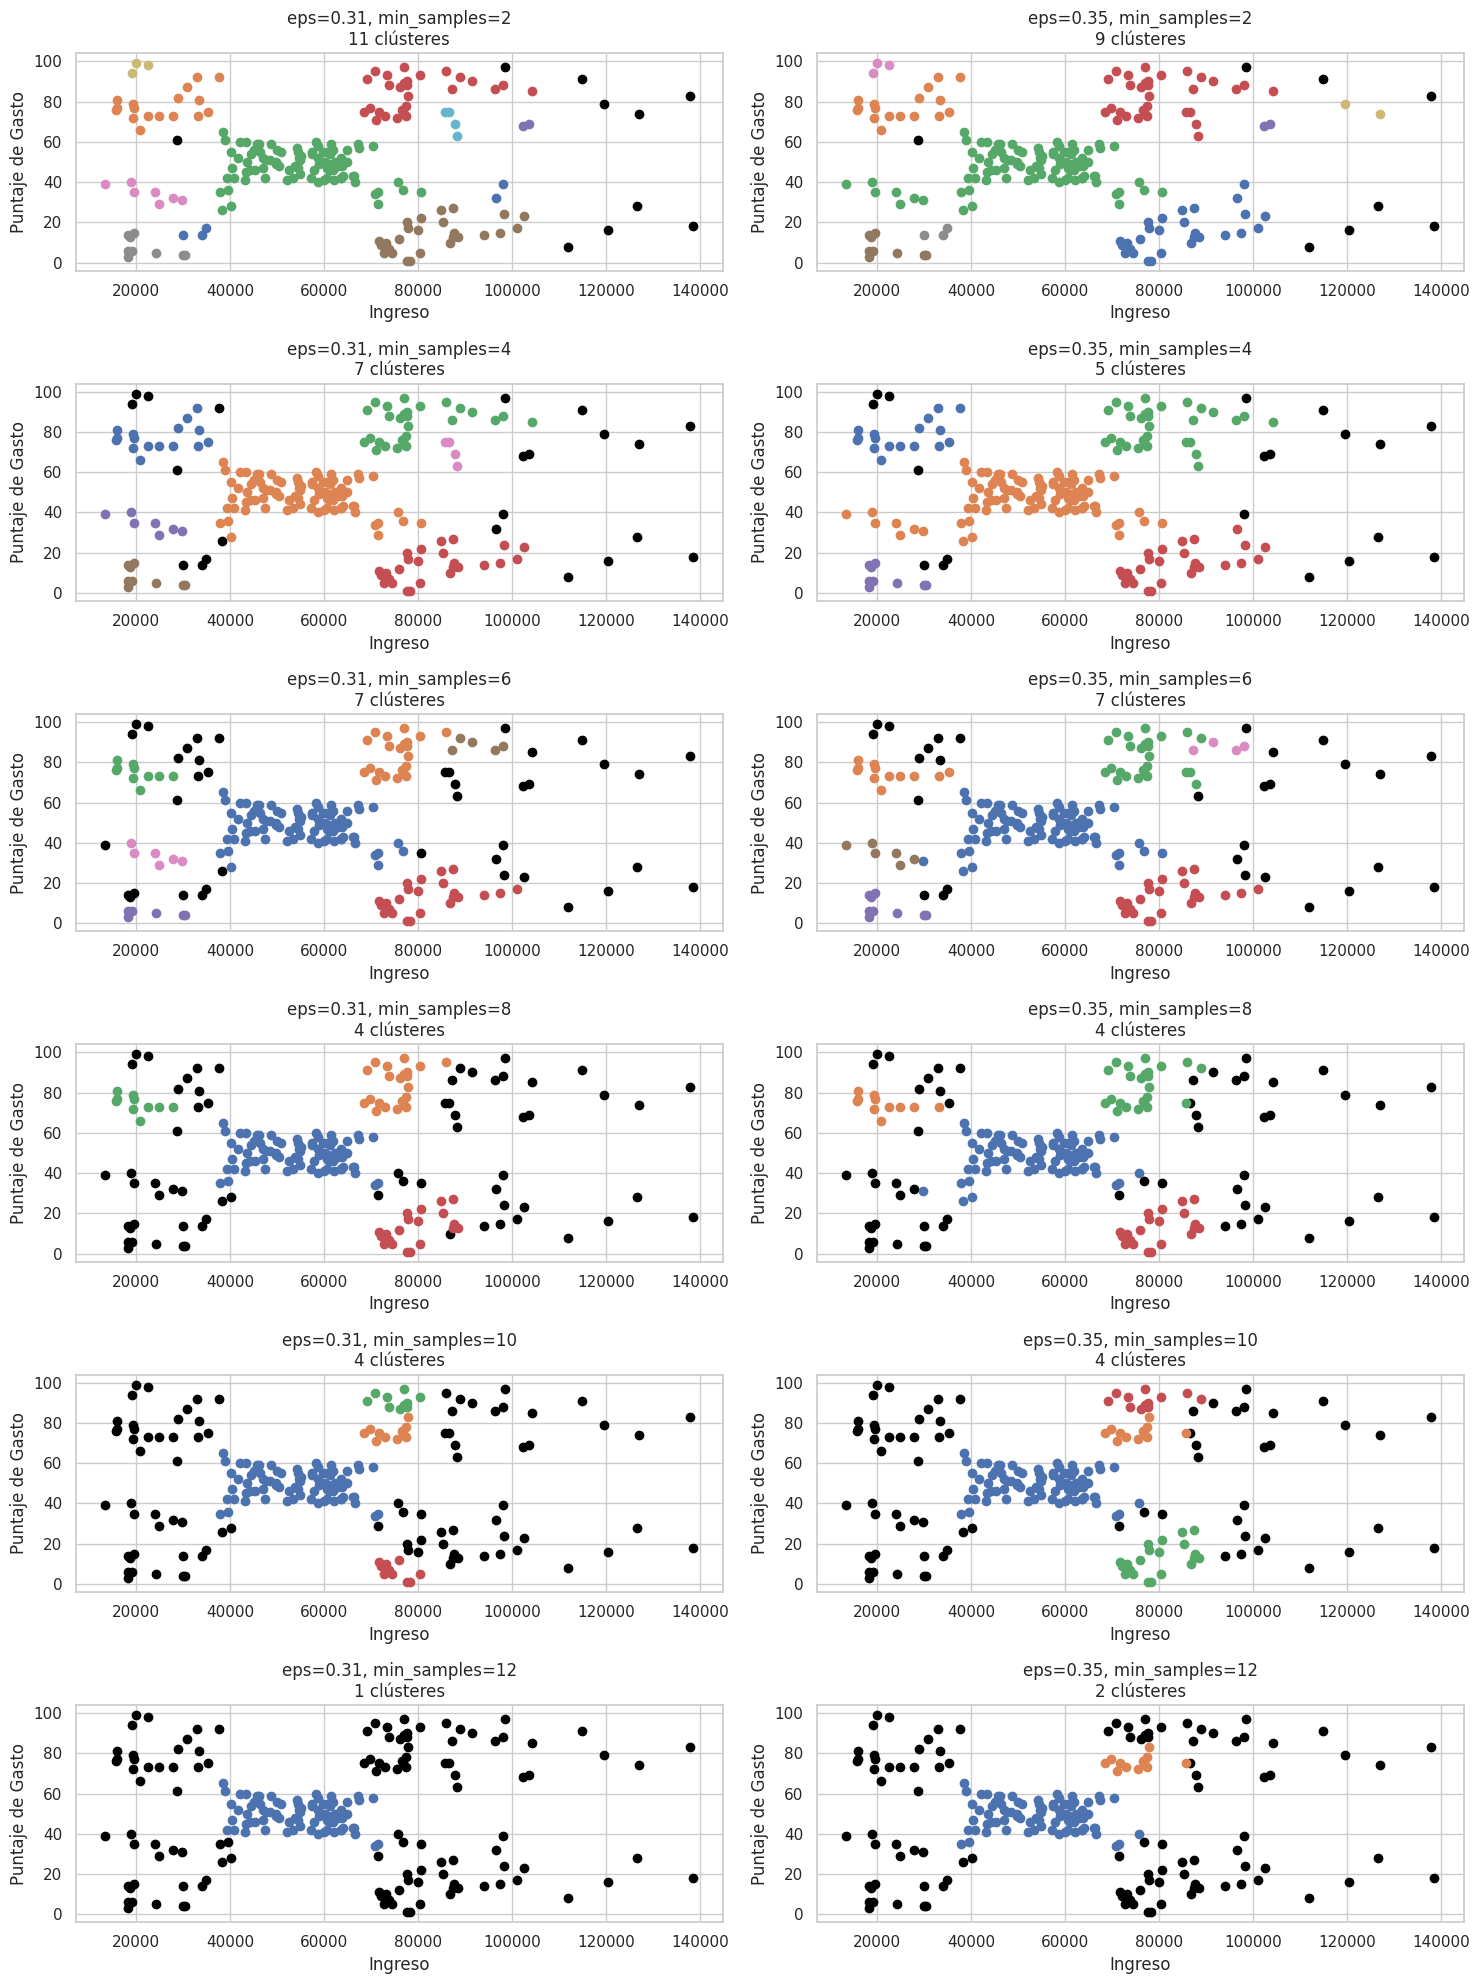

In [19]:
# Definir los valores de min_samples para experimentar
eps_new = [0.31, 0.35]
min_samples_list = [2, 4, 6, 8, 10, 12]

# Graficar los clusters para cada combinación de eps y min_samples
plt.figure(figsize=(15, 20))
plot_num = 1

for min_samples in min_samples_list:
    for eps in eps_new:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(variables_scaled)
        clusteres = db.labels_
        n_clusteres = len(set(clusteres)) - (1 if -1 in clusteres else 0)
        resultado = pd.DataFrame(variables, columns=variables.columns).assign(Cluster=clusteres)

        # Crear subplot para cada combinación de eps y min_samples
        plt.subplot(len(min_samples_list), len(eps_new), plot_num)
        for k in np.unique(clusteres):
            if k != -1:
                plt.scatter(
                    x=resultado.loc[resultado.Cluster == k, 'Ingreso'],
                    y=resultado.loc[resultado.Cluster == k, 'Puntaje_Gasto'],
                    label=f'Cluster {k}'
                )
            else:
                plt.scatter(
                    x=resultado.loc[resultado.Cluster == k, 'Ingreso'],
                    y=resultado.loc[resultado.Cluster == k, 'Puntaje_Gasto'],
                    c="black", label='Ruido'
                )
        plt.title(f'eps={eps:.2f}, min_samples={min_samples}\n{n_clusteres} clústeres')
        plt.xlabel('Ingreso')
        plt.ylabel('Puntaje de Gasto')
        plot_num += 1

plt.tight_layout()
plt.show()

**Procedimiento**

Ya que se obtuvieron dos posibles valores óptimos para eps,
es importante definir el valor óptimo de min_samples, por lo que se probaron diferentes combinaciones con valores de min_samples de 2, 4, 6, 8, 10 y 12. Se graficó la distribución de los clusters en Ingreso vs Puntaje_Gasto y se determinó visualmente los valores que mejor se ajustaban al dataset.

**Análisis**
- Se observa con eps=0.31 se tiende a formar en casi todas las combinaciones un mayor número de clusters, que si se utilizara 0.35.
- De acuerdo al análisis visual se determina que el valor de min_samples más apropiado para estos datos es 4.

**Conclusiones**
- El eps óptimo definido es 0.35 y el mejor min_samples es 4, como lo sugiere la literatura, por lo que su elección se basa en la coherencia de formación de clusters, puesto que distintos valores a estos forman o muchos clusters o pocos clusters que no son coherentes con los valores de ingresos y puntaje de gastos en que se agrupan. A partir de estos valores y usando el método de DBSCAN se obtienen 5 clusters y algunos puntos definidos como ruido. Esto permite una mejor interpretación y aplicación de estrategias de marketing basadas en las diferencias significativas en ingresos y gastos.

#### Mejor modelo

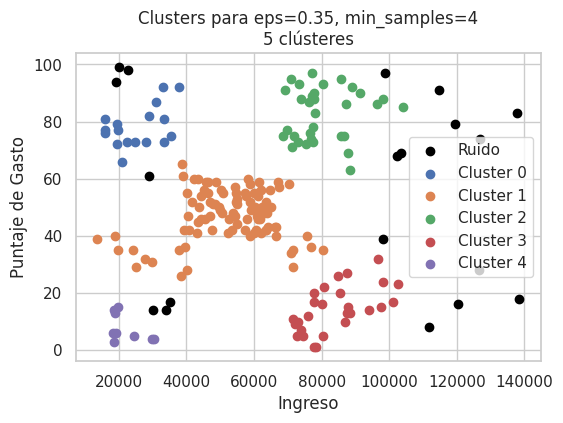

In [20]:
df_dbscan = df.copy()

best_eps = 0.35
best_min_samples = 4

# Ajustar DBSCAN con los mejores parámetros
db = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(variables_scaled)
clusteres_dbscan = db.labels_
df_dbscan['Clusters_dbscan'] = clusteres_dbscan

# Número de clusters, excluyendo el ruido (-1)
n_clusteres = len(set(clusteres_dbscan)) - (1 if -1 in clusteres_dbscan else 0)

# Crear un DataFrame para los resultados
resultado = pd.DataFrame(variables, columns=variables.columns).assign(Cluster=clusteres_dbscan)

# Graficar los resultados
plt.figure(figsize=(6, 4))
for k in np.unique(clusteres_dbscan):
    if k != -1:
        plt.scatter(
            x=resultado.loc[resultado.Cluster == k, 'Ingreso'],
            y=resultado.loc[resultado.Cluster == k, 'Puntaje_Gasto'],
            label=f'Cluster {k}'
        )
    else:
        plt.scatter(
            x=resultado.loc[resultado.Cluster == k, 'Ingreso'],
            y=resultado.loc[resultado.Cluster == k, 'Puntaje_Gasto'],
            c="black", label='Ruido'
        )

plt.title(f'Clusters para eps={best_eps:.2f}, min_samples={best_min_samples}\n{n_clusteres} clústeres')
plt.xlabel('Ingreso')
plt.ylabel('Puntaje de Gasto')
plt.legend()
plt.show()

In [21]:
# Obtención de estadísticas descriptivas
df_dbscan_flt = df_dbscan.drop(columns=['Id_Cliente'])
desc_stats_dbscan_flt = df_dbscan_flt.groupby('Clusters_dbscan').describe()
desc_stats_dbscan_flt.T

Clusters_dbscan                 -1             0             1              2  \
Edad          count      19.000000     17.000000     96.000000      32.000000   
              mean       36.631579     23.764706     42.354167      32.812500   
              std         7.882544      3.961209     15.927453       3.838998   
              min        23.000000     18.000000     18.000000      27.000000   
              25%        32.000000     21.000000     27.000000      30.000000   
              50%        35.000000     23.000000     45.000000      32.000000   
              75%        41.500000     25.000000     53.250000      36.000000   
              max        54.000000     31.000000     70.000000      40.000000   
Ingreso       count      19.000000     17.000000     96.000000      32.000000   
              mean    83648.104211  25603.968824  52772.790313   80345.731875   
              std     45906.324889   7448.438195  12991.372495    8978.959662   
              min     19113.290000  15766.840000  13458.020000   68486.790000   
              25%     32075.005000  19460.970000  44409.867500   73754.440000   
              50%    102348.090000  24905.790000  54643.120000   77465.110000   
              75%    119977.490000  32982.990000  61904.847500   86734.860000   
              max    138584.520000  37682.870000  80565.010000  104232.750000   
Puntaje_Gasto count      19.000000     17.000000     96.000000      32.000000   
              mean       56.157895     78.176471     47.312500      82.562500   
              std        34.442001      7.081978      8.646645       9.119060   
              min         8.000000     66.000000     26.000000      63.000000   
              25%        17.500000     73.000000     42.000000      75.000000   
              50%        68.000000     77.000000     48.000000      85.500000   
              75%        87.000000     81.000000     55.000000      90.000000   
              max        99.000000     92.000000     65.000000      97.000000   

Clusters_dbscan                  3             4  
Edad          count      27.000000      9.000000  
              mean       41.259259     48.888889  
              std        11.729623     15.640048  
              min        19.000000     20.000000  
              25%        35.000000     37.000000  
              50%        42.000000     53.000000  
              75%        48.500000     60.000000  
              max        59.000000     67.000000  
Ingreso       count      27.000000      9.000000  
              mean    83900.610000  21971.123333  
              std      9487.720558   5054.104594  
              min     71651.080000  18284.380000  
              25%     76822.640000  18437.210000  
              50%     80575.780000  19281.750000  
              75%     88142.880000  24402.320000  
              max    102643.750000  30542.080000  
Puntaje_Gasto count      27.000000      9.000000  
              mean       14.444444      7.777778  
              std         8.025600      4.790036  
              min         1.000000      3.000000  
              25%         9.500000      4.000000  
              50%        14.000000      6.000000  
              75%        20.000000     13.000000  
              max        32.000000     15.000000

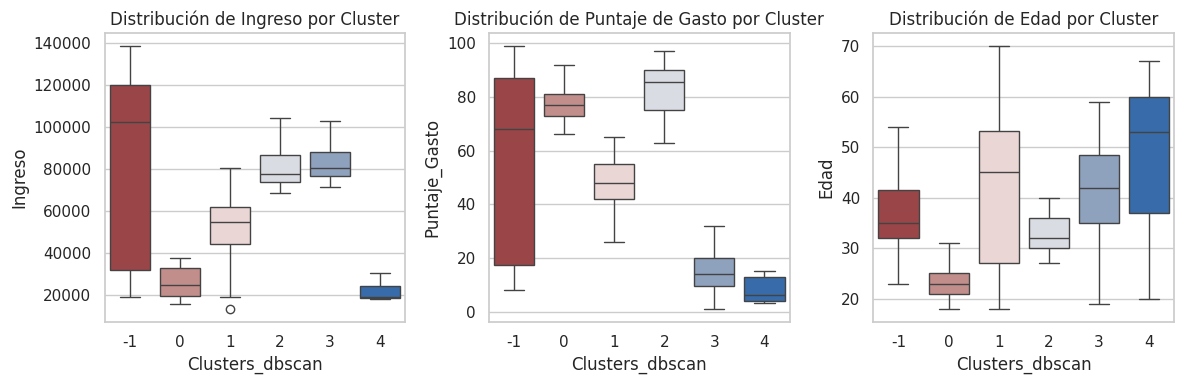

In [22]:
boxplots_clusters(df_dbscan_flt, 'Clusters_dbscan')

#### Procedimiento, análisis y conclusiones

**Procedimiento**
Despues de calcular el eps y min_samples óptimos, se estimó con estos valores el modelo usando DBSCAN. Posteriormente, se obtuvieron las estadísticas descriptivas y los diagramas de boxplots para caracterizar cada cluster.

**Análisis**
- El Cluster 0 agrupa clientes con edades principalmente entre 21 y 25 años (jóvenes), los cuales tienen puntajes de gasto altos pero ingresos bajos.
- El Cluster 1 se conforma en su mayoria por usuarios con un rango de edad más amplio, principalmente entre 27 y 53 años, los cuales tienen el rango más amplio de ingresos pero se concentran los valores entre los 44000 y 62000 dolares (ingresos intermedios), y tambien con puntajes de gastos intermedios.
- El Cluster 2 tiene el rango más restringido de edades y varia entre 28 y 40 años. Los clientes que conforman este cluster tienen ingresos altos y altos puntajes de gasto.
- El Cluster 3 agrupa clientes con un rango de edades muy amplio, entre 20 y 60 años, donde sus ingresos son relativamente altos, pero los puntajes de gasto son muy bajos, no superando los 40 puntos.
- El Cluster 4, abarca también un especto amplio de edades desde los 20 hasta los 70 años, y dichos clientes tienen ingresos anuales y puntakes de gasto muy bajos que no alcanzan en esta última variable los 20 puntos.
- El Cluster -1 agrupa el ruido, por lo que no es considerado viable para una campaña de marketing, sin embargo, tiene un amplio rango de ingresos anuales y puntajes de gasto, pero está conformado principalmente por usuarios con edades entre 32 y 42 años.

El cluster más atractivo para las estrategias de marketing es el Cluster 2, ya que al igual que el cluster definidido con cluster jerarquico aglomerativo de estas mismas características, presentan altos ingresos y altos puntajes de gasto, y se concentran en edades muy similares, por lo que la estrategia de fidelización no se cambiaria en este caso.

Por otra parte, el Cluster 4 encontrado en Jerárquico algomerativo es similar al Cluster 1 con DBSCAN, cuyos ingresos y puntajes de gasto son intermedios, y con un amplio espectro de edades, por lo que también se mantendria las estrategias de marketing más generales o diversificadas.

El Cluster 0 definido en cluster jerárquico aglomerativo tiene tendencias similares al Cluster 3 obtenido en DBSCAN, sin embargo, los valores de puntajes ded gastos son un poco más bajos, por lo que se podria utilizar la misma estrategia de marketing pero con más agresividad para que potencie la iniciativa de gasto en estos clientes.

**Conclusiones**

Aunque los grupos obtenidos con DBSCAN muestran similitudes con los del clustering jerárquico, el método DBSCAN ofrece una ventaja significativa al distinguir entre ruido y clusters. Esto permite una segmentación más precisa, excluyendo datos atípicos que podrían no reflejar adecuadamente el comportamiento del cliente. Como resultado, las estrategias de marketing basadas en DBSCAN pueden ser más efectivas, al centrarse en clientes que representan de manera más precisa cada grupo.

En general, las estrategias de marketing desarrolladas utilizando el método jerárquico aún pueden ser válidas. Sin embargo, con la información más refinada proporcionada por DBSCAN, se podria optimizar estas estrategias para mejorar su efectividad, focalizándose en los segmentos de clientes más representativos y relevantes.

### 5.Incorporando más dimensiones

Hasta este momento hemos utilizado solo dos variables para nuestro análisis, sin embargo, la base cuenta con otras variables más: género y edad. Usando las categorías de edad creadas anteriormente incorpore género y grupo etario a su análisis. Genere los grupos utilizando DBSCAN y la distancia de Gower, justificando su elección de `min_samples` y `eps`   ¿Incorporar estas variables, ayuda a la focalización de la estrategia de marketing?

#### Selección de hiperparámetros con grid search

In [23]:
X_db = df_filtered[['Ingreso', 'Puntaje_Gasto', 'Grupo_Etario', 'Genero']]

# 1. Escalar las variables numéricas
scaler = MinMaxScaler()
df[['Ingreso', 'Puntaje_Gasto']] = scaler.fit_transform(X_db[['Ingreso', 'Puntaje_Gasto']])

# 2. Codificación de variables categóricas
encoder = OneHotEncoder()
categorical_encoded = encoder.fit_transform(X_db[['Grupo_Etario', 'Genero']]).toarray()

# Crear un nuevo DataFrame con las variables escaladas y codificadas
column_names = ['Ingreso', 'Puntaje_Gasto'] + list(encoder.get_feature_names_out(['Grupo_Etario', 'Genero']))
df_encoded = pd.DataFrame(np.hstack([df[['Ingreso', 'Puntaje_Gasto']], categorical_encoded]), columns=column_names)

# Se elimina una de las categorias para que las variables no estén correlacionadas
X_scale =  df_encoded.drop(columns=['Grupo_Etario_65+', 'Genero_Hombre'])
X_scale.head()

,Ingreso,Puntaje_Gasto,Grupo_Etario_18-24,Grupo_Etario_25-34,Grupo_Etario_35-44,Grupo_Etario_45-54,Grupo_Etario_55-64,Genero_Mujer
0,0.676572,0.387755,0.0,0.0,1.0,0.0,0.0,1.0
1,0.175823,0.755102,1.0,0.0,0.0,0.0,0.0,1.0
2,0.370937,0.551020,0.0,0.0,0.0,0.0,0.0,1.0
3,0.280124,0.510204,0.0,0.0,0.0,0.0,1.0,0.0
4,0.247534,0.540816,0.0,1.0,0.0,0.0,0.0,1.0


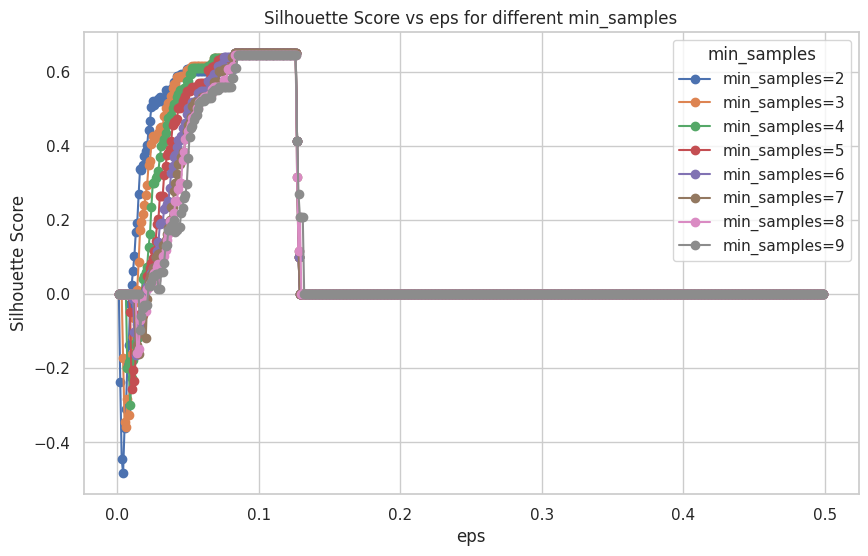

Mejor valor de eps: 0.083
Mejor valor de min_samples: 2


In [24]:
# Calculo de la distancia de gower
dist_matrix = gower.gower_matrix(X_scale)

# Grid search para encontrar el mejor eps y min_samples
eps_values = np.arange(0.001, 0.5, 0.001)
min_samples_values = range(2, 10)
best_score = -1
best_params = {'eps': None, 'min_samples': None}
silhouette_scores_grid = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(metric='precomputed', eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(dist_matrix)

        # Calcular el score de Silhouette, ignorando los outliers (-1)
        if len(set(clusters)) > 1 and len(set(clusters)) < len(X_scale):
            score = silhouette_score(dist_matrix, clusters, metric='precomputed')
            silhouette_scores_grid.append((eps, min_samples, score))

            if score > best_score:
                # Actualizar los mejores parámetros si se encuentra un mejor score
                best_score = score
                best_params['eps'] = eps
                best_params['min_samples'] = min_samples
        else:
            silhouette_scores_grid.append((eps, min_samples, np.nan))

# Verificar si se encontraron parámetros válidos
if best_params['eps'] is None or best_params['min_samples'] is None:
    raise ValueError("No se encontraron combinaciones válidas de eps y min_samples que formen clusters adecuados.")

# Gráfica de Silhouette vs eps y min_samples
plt.figure(figsize=(10, 6))
for min_samples in min_samples_values:
    scores = [score for eps, ms, score in silhouette_scores_grid if ms == min_samples]

    # Filtrar solo los valores válidos
    valid_scores = [s if not np.isnan(s) else 0 for s in scores]

    plt.plot(eps_values, valid_scores, marker='o', label=f'min_samples={min_samples}')

plt.title('Silhouette Score vs eps for different min_samples')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.legend(title='min_samples')
plt.grid(True)
plt.show()

# 7. Mejor combinación de eps y min_samples
best_eps_gower = best_params['eps']
best_min_samples_gower = best_params['min_samples']
print(f"Mejor valor de eps: {best_eps_gower}")
print(f"Mejor valor de min_samples: {best_min_samples_gower}")

#### Mejor modelo

In [25]:
df_dbscan = df.copy()

# 8. Usar estos parámetros para el DBSCAN final
dbscan_final = DBSCAN(metric='precomputed', eps=best_eps_gower, min_samples=best_min_samples_gower)
clusters_gower_db = dbscan_final.fit_predict(dist_matrix)

# 9. Agregar los clusters al DataFrame original
X_scale['Cluster_gower'] = clusters_gower_db

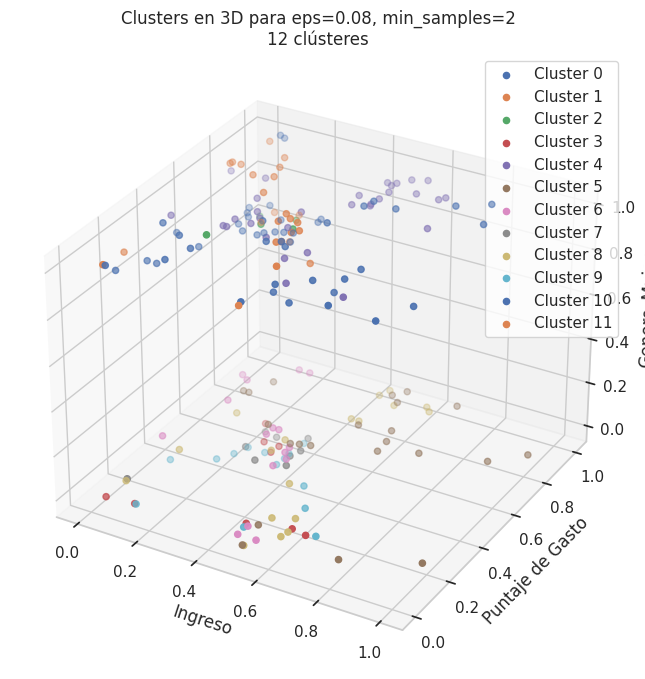

In [26]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Número de clusters, excluyendo el ruido (-1)
n_clusteres = len(set(clusters_gower_db)) - (1 if -1 in clusters_gower_db else 0)

# Muestra los puntos para cada cluster
for k in np.unique(clusters_gower_db):
    cluster_data = X_scale[X_scale['Cluster_gower']  == k]

    # Puedes cambiar 'Otra_Dimensión' por cualquier otra columna que desees visualizar
    if k != -1:
        ax.scatter(
            cluster_data['Ingreso'],
            cluster_data['Puntaje_Gasto'],
            cluster_data['Genero_Mujer'],  # Cambia esto por la tercera dimensión de interés
            label=f'Cluster {k}'
        )
    else:
        ax.scatter(
            cluster_data['Ingreso'],
            cluster_data['Puntaje_Gasto'],
            cluster_data['Genero_Mujer'],  # Cambia esto por la tercera dimensión de interés
            c="black", label='Ruido'
        )

ax.set_title(f'Clusters en 3D para eps={best_eps_gower:.2f}, min_samples={best_min_samples_gower}\n{n_clusteres} clústeres')
ax.set_xlabel('Ingreso')
ax.set_ylabel('Puntaje de Gasto')
ax.set_zlabel('Genero_Mujer')  # Cambia la etiqueta por la dimensión que elegiste
ax.legend()
plt.show()

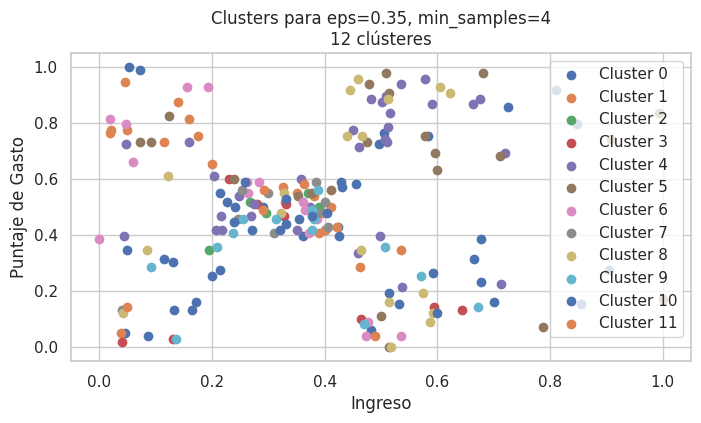

In [27]:


# Crear un DataFrame para los resultados
resultado = pd.DataFrame(X_scale, columns=variables.columns).assign(Cluster=clusters_gower_db)

# Graficar los resultados
plt.figure(figsize=(8, 4))
for k in np.unique(clusters_gower_db):
    if k != -1:
        plt.scatter(
            x=resultado.loc[resultado.Cluster == k, 'Ingreso'],
            y=resultado.loc[resultado.Cluster == k, 'Puntaje_Gasto'],
            label=f'Cluster {k}'
        )
    else:
        plt.scatter(
            x=resultado.loc[resultado.Cluster == k, 'Ingreso'],
            y=resultado.loc[resultado.Cluster == k, 'Puntaje_Gasto'],
            c="black", label='Ruido'
        )

plt.title(f'Clusters para eps={best_eps:.2f}, min_samples={best_min_samples}\n{n_clusteres} clústeres')
plt.xlabel('Ingreso')
plt.ylabel('Puntaje de Gasto')
plt.legend()
plt.show()

In [28]:
# Obtención de estadísticas descriptivas
desc_stats_dbscan_gower = X_scale.groupby('Cluster_gower').describe()
print(desc_stats_dbscan_gower)

              Ingreso                                                    \
                count      mean       std       min       25%       50%   
Cluster_gower                                                             
0                24.0  0.427291  0.252193  0.046543  0.192568  0.469339   
1                19.0  0.232287  0.157835  0.018452  0.082899  0.200927   
2                 5.0  0.304172  0.079141  0.195547  0.267829  0.296274   
3                 9.0  0.338235  0.200553  0.039774  0.230199  0.327810   
4                32.0  0.418435  0.184211  0.044319  0.263495  0.471984   
5                22.0  0.523226  0.261611  0.072517  0.386292  0.510947   
6                16.0  0.266054  0.171947  0.000000  0.132079  0.273279   
7                 9.0  0.302964  0.116500  0.039793  0.253855  0.309629   
8                18.0  0.427919  0.179814  0.042670  0.356485  0.464976   
9                14.0  0.356208  0.164016  0.092193  0.241885  0.378046   
10               25.0  0.

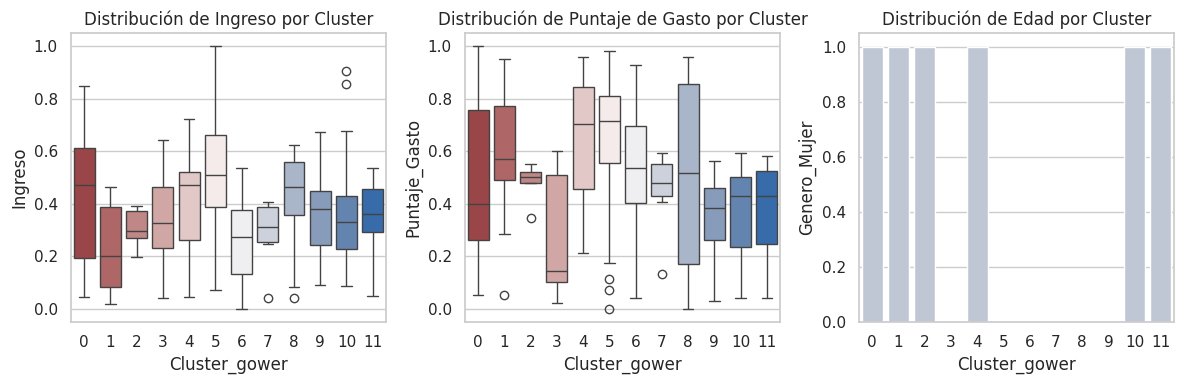

In [29]:
# Configuración de estilo para las gráficas
sns.set(style="whitegrid")

# Gráficas de estadísticas descriptivas por género
plt.figure(figsize=(12, 4))

# Ingreso de acuerdo a cada cluster
plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster_gower', y='Ingreso', data=X_scale, hue='Cluster_gower', palette="vlag_r", legend=False)
plt.title('Distribución de Ingreso por Cluster')

# Puntaje de acuerdo a cada cluster
plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster_gower', y='Puntaje_Gasto', data=X_scale, hue='Cluster_gower', palette="vlag_r", legend=False)
plt.title('Distribución de Puntaje de Gasto por Cluster')

# Género de acuerdo a cada cluster
plt.subplot(1, 3, 3)
sns.barplot(x='Cluster_gower', y='Genero_Mujer', data=X_scale, hue='Genero_Mujer', palette="vlag_r", legend=False)
plt.title('Distribución de Edad por Cluster')

plt.tight_layout()
plt.show()

#### Procedimiento, análisis y conclusiones

**Procedimiento**
Se creo un dataframe con las variables solicitadas. Posteriormente, se estandarizaron los datos cuantitativo, mientras para las variables categóricas se utilizo OneHotEncoder. Se obtuvo un nuevo dataframe estandarizado, donde se eliminó una de las categorias de las variables para evitar información redundante.

Se calculo la matriz de distancia de gower, y se buscó con grid search los mejores hiperparámetros de DBSCAN (eps y min_samples) utilizando como métrica el indice de Silhouette, se probaron combinacines de valores de eps entre 0.001 y 0.5 cada 0.001, y min samples entre 2 y 10. Despues de encontrar los mejores valores, se calculo el modelo final de DBSCAN y se obtuvieron los clusters.

Luego, se realizaron gráficos en 3D que aunque no muestra todas las dimensiones del input, nos da una idea de como se está distribuyendo los clusters de acuerdo a las características de Ingreso, Puntaje_Gasto y Género. Para visualizar mejor los resultados se calculó el plot de Ingreso vs Puntaje_Gasto. Finalmente, se obtuvieron las estadísticas descriptivas y boxplots de categorias importantes.

**Análisis**
* Al buscar los mejores hiperparámetros es notable que el valor óptimo de eps cambian sustancialmente con respecto al encontrado para el punto 4. Esto probablemente se deba al cambio en la estimación de las distancias, previamente se utilizó la distancia euclidiana, y en este punto utilizamos la distancia de gower.
* El mejor valor de eps es de 0.083 y el valor óptimo de min_samples es de 2. Con estos hiperparámetros se obtuvieron 12 clusters, excluyendo el ruido.
* Con el gráfico en 3D se puede observar que la distribución de los clusters están más relacionados con el género, que con las variables de Ingreso y Puntaje_Gasto. Lo cual es corroborado en el grafico 2D Ingreso vs Puntaje_Gasto, donde los clusters parecen no tener un patrón particular en estas categorias.
* Los boxplots revelan una amplia variabilidad en Ingreso y Puntaje_Gasto dentro de los clusters, con varios valores atípicos en algunos casos. Esta variabilidad sugiere que los clusters no están claramente diferenciados en términos de estas métricas. Los resultados obtenidos pueden ser útiles para enfocar estrategias de marketing basadas en el género y los grupos etarios, ya que el género parece ser un factor más determinante en la formación de los clusters que las métricas económicas evaluadas.

**Conclusiones**

El análisis utilizando DBSCAN con distancia de Gower deacuerdo a la indice de Silhoutte reveló que el valor óptimo de eps es 0.083 y min_samples es 2, resultando en 12 clusters identificados. A diferencia de la métrica de distancia euclidiana y al incluir más variables, la distancia de Gower proporcionó una estructura de clusters que indica una mayor influencia del género sobre la formación de clusters que las variables Ingreso y Puntaje_Gasto. Los gráficos en 3D y 2D mostraron que, aunque la distribución de los clusters no presenta patrones claros en términos de ingresos y puntaje de gasto, el género parece ser un factor clave en la agrupación. Los boxplots indican una alta variabilidad en Ingreso y Puntaje_Gasto dentro de los clusters, sugiriendo que los resultados pueden ser utilizados para diseñar estrategias de marketing focalizadas en función del género y los grupos etarios, más que en características económicas específicas.